In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
import numpy as np

def make_blob_and_noise_dist_uniform(n_samples, dist=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[0, 0]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    
    X = np.vstack((X, centers[0] + dist))
    l = np.hstack((l, [-1]))
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
dists = np.arange(0, 15.1, 0.5)
blob_noise_dist_datasets = [
    [make_blob_and_noise_dist_uniform(500, dist=dist, seed=seed) for seed in random_seeds] for dist in dists
]

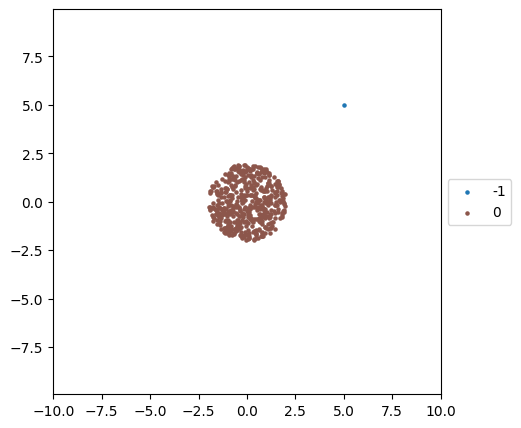

In [3]:
import matplotlib.pyplot as plt


# X, l = make_blobs_dist(500, 5, 0)
X, l = make_blob_and_noise_dist_uniform(500, 5, 0)

plt.figure(figsize=(5, 5))
color = plt.cm.tab20(np.linspace(0, 1, len(set(l)) + 1))
for c_id in np.sort(list(set(l))):
    plt.scatter(
        X[:, 0][l == c_id], X[:, 1][l == c_id], s=5, color=color[int(c_id) + 1], label=int(c_id)
    )
legend = plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax = plt.gca()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
ax.set_aspect("equal", adjustable="datalim")

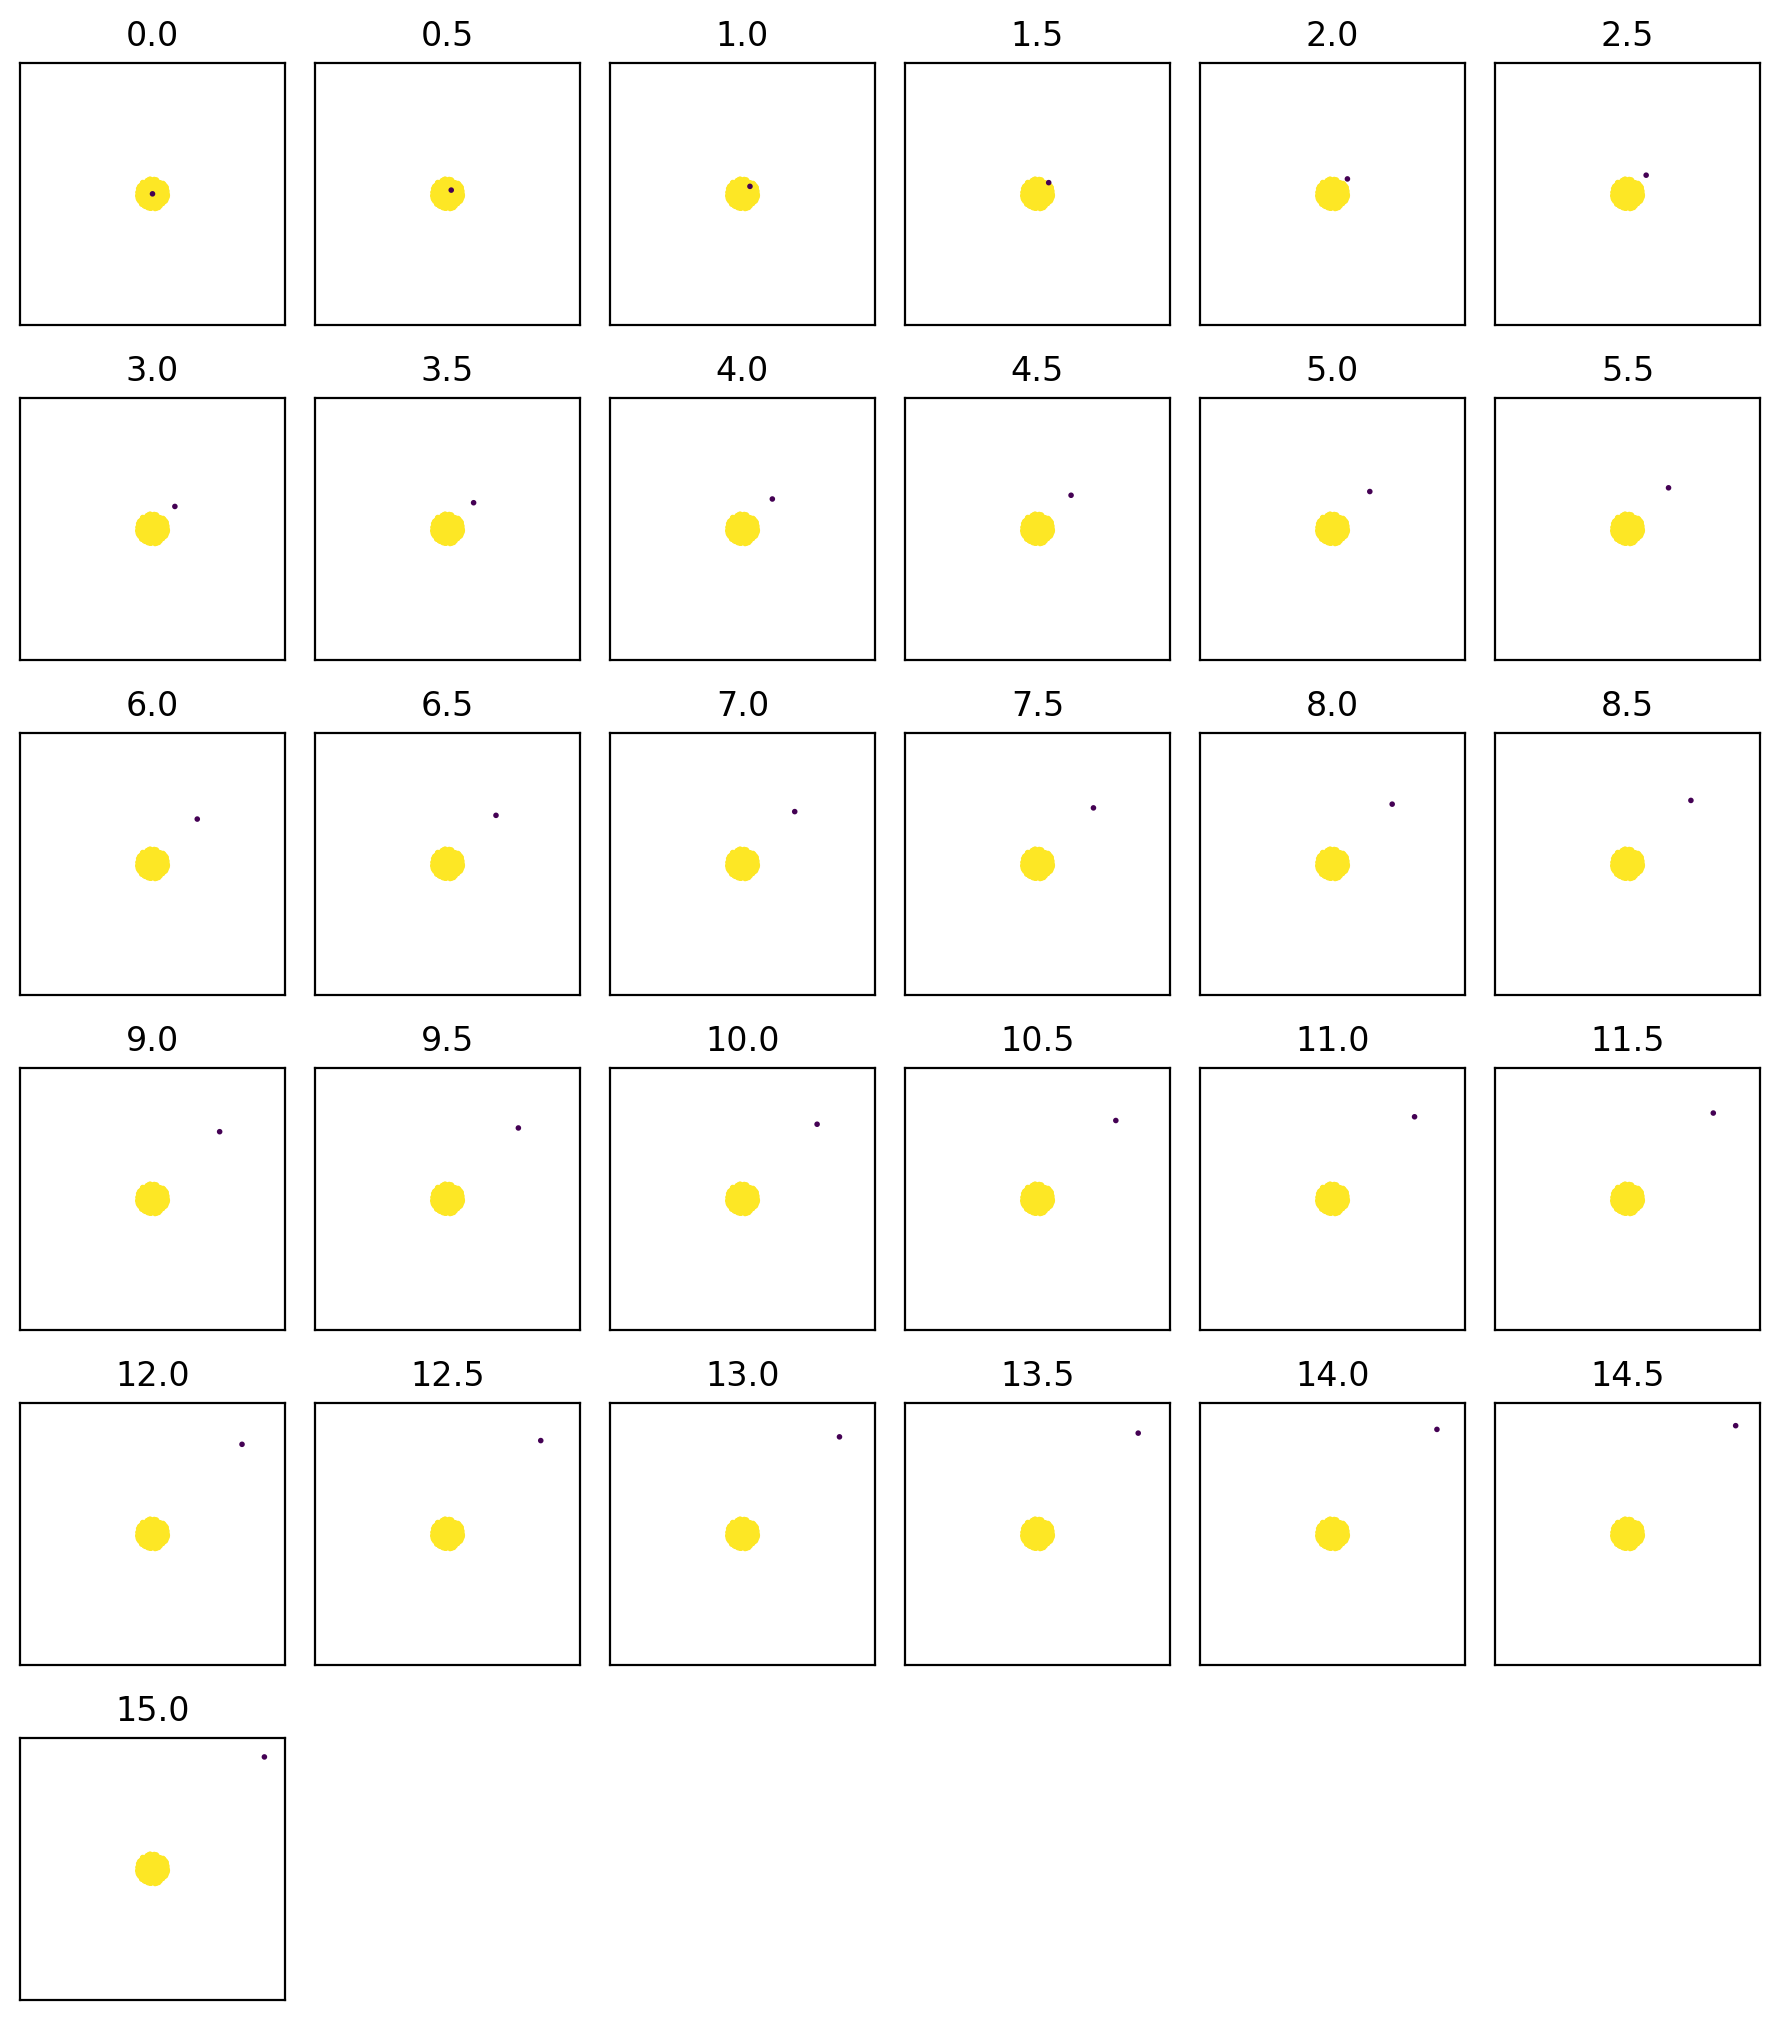

In [4]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets
from src.utils.data import sample_datasets

fig = plot_datasets(blob_noise_dist_datasets, dists, n_cols=6, figsize=1.5)

axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/Noise_dist_data.png", bbox_inches="tight", pad_inches=0)

In [171]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.disco import disco_samples, p_noise, p_cluster, disco_score

metrics = {
    "DISCO": disco_score,
    "$\\rho_{cluster}$": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "$\\rho_{sparse}$": lambda X, l: np.mean(p_noise(X, l)[0]),
    "$\\rho_{far}$": lambda X, l: np.mean(p_noise(X, l)[1]),
}

eval_results = cache(
    "Noise_dist",
    calc_eval_measures_for_multiple_datasets,
    [blob_noise_dist_datasets, dists],
    {"metrics": metrics},
    recalc=False,
)

df2 = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[])

In [172]:
df2 = df2[df2["dataset"] <= 5]

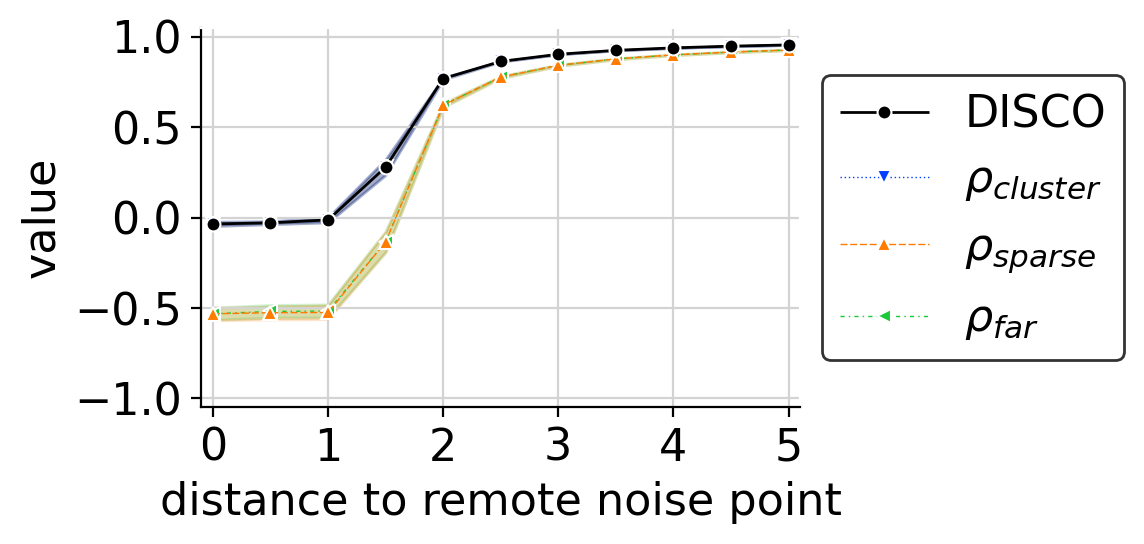

In [173]:
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = dists[0] - eps, dists[-1] + eps
x_range = -0.1, 5.1

fig1 = plot_lineplot(df2, "dataset", "value", "measure", x_label="distance to remote noise point", x_range=x_range, y_range=(-1.05, 1.05), order=list(metrics.keys()), figsize=(6,3), highlight=1, ncol=1)
ax1 = fig1.gca()
ax1.set_xticks(range(0, 6, 1))
ax1.set_yticks(np.arange(-1,1.04, 0.5))
leg = ax1.get_legend()
leg.set_loc("center left")
leg.set_bbox_to_anchor((1, 0.5))
plt.savefig("imgs/Noise_dist.png", bbox_inches="tight", pad_inches=0)

In [11]:
import numpy as np

def make_blob_and_noise_grow_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[0, 0], [15, 15]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        if i == 0:
            n_cluster = n_samples
        if i == 1:
            n_cluster = n_noise
        while len(X_i) < n_cluster:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_cluster * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_cluster - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    l[l == 1] = -1
    return X, l


np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
n_noises = np.hstack(([1], np.arange(50, 1501, 50)))
blob_noise_grow_datasets = [
    [make_blob_and_noise_grow_uniform(500, n_noise=n_noise, seed=seed) for seed in random_seeds]
    for n_noise in n_noises
]

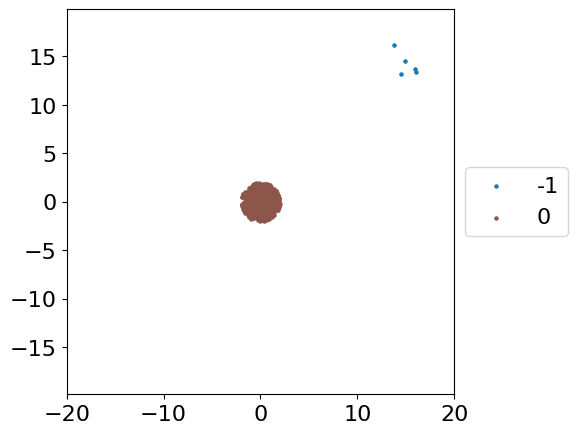

In [12]:
import matplotlib.pyplot as plt


X, l = make_blob_and_noise_grow_uniform(500, 5, 0)

plt.figure(figsize=(5, 5))
color = plt.cm.tab20(np.linspace(0, 1, len(set(l)) + 1))
for c_id in np.sort(list(set(l))):
    plt.scatter(
        X[:, 0][l == c_id], X[:, 1][l == c_id], s=5, color=color[int(c_id) + 1], label=int(c_id)
    )
legend = plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
ax = plt.gca()
plt.ylim(-20, 20)
plt.xlim(-20, 20)
ax.set_aspect("equal", adjustable="datalim")

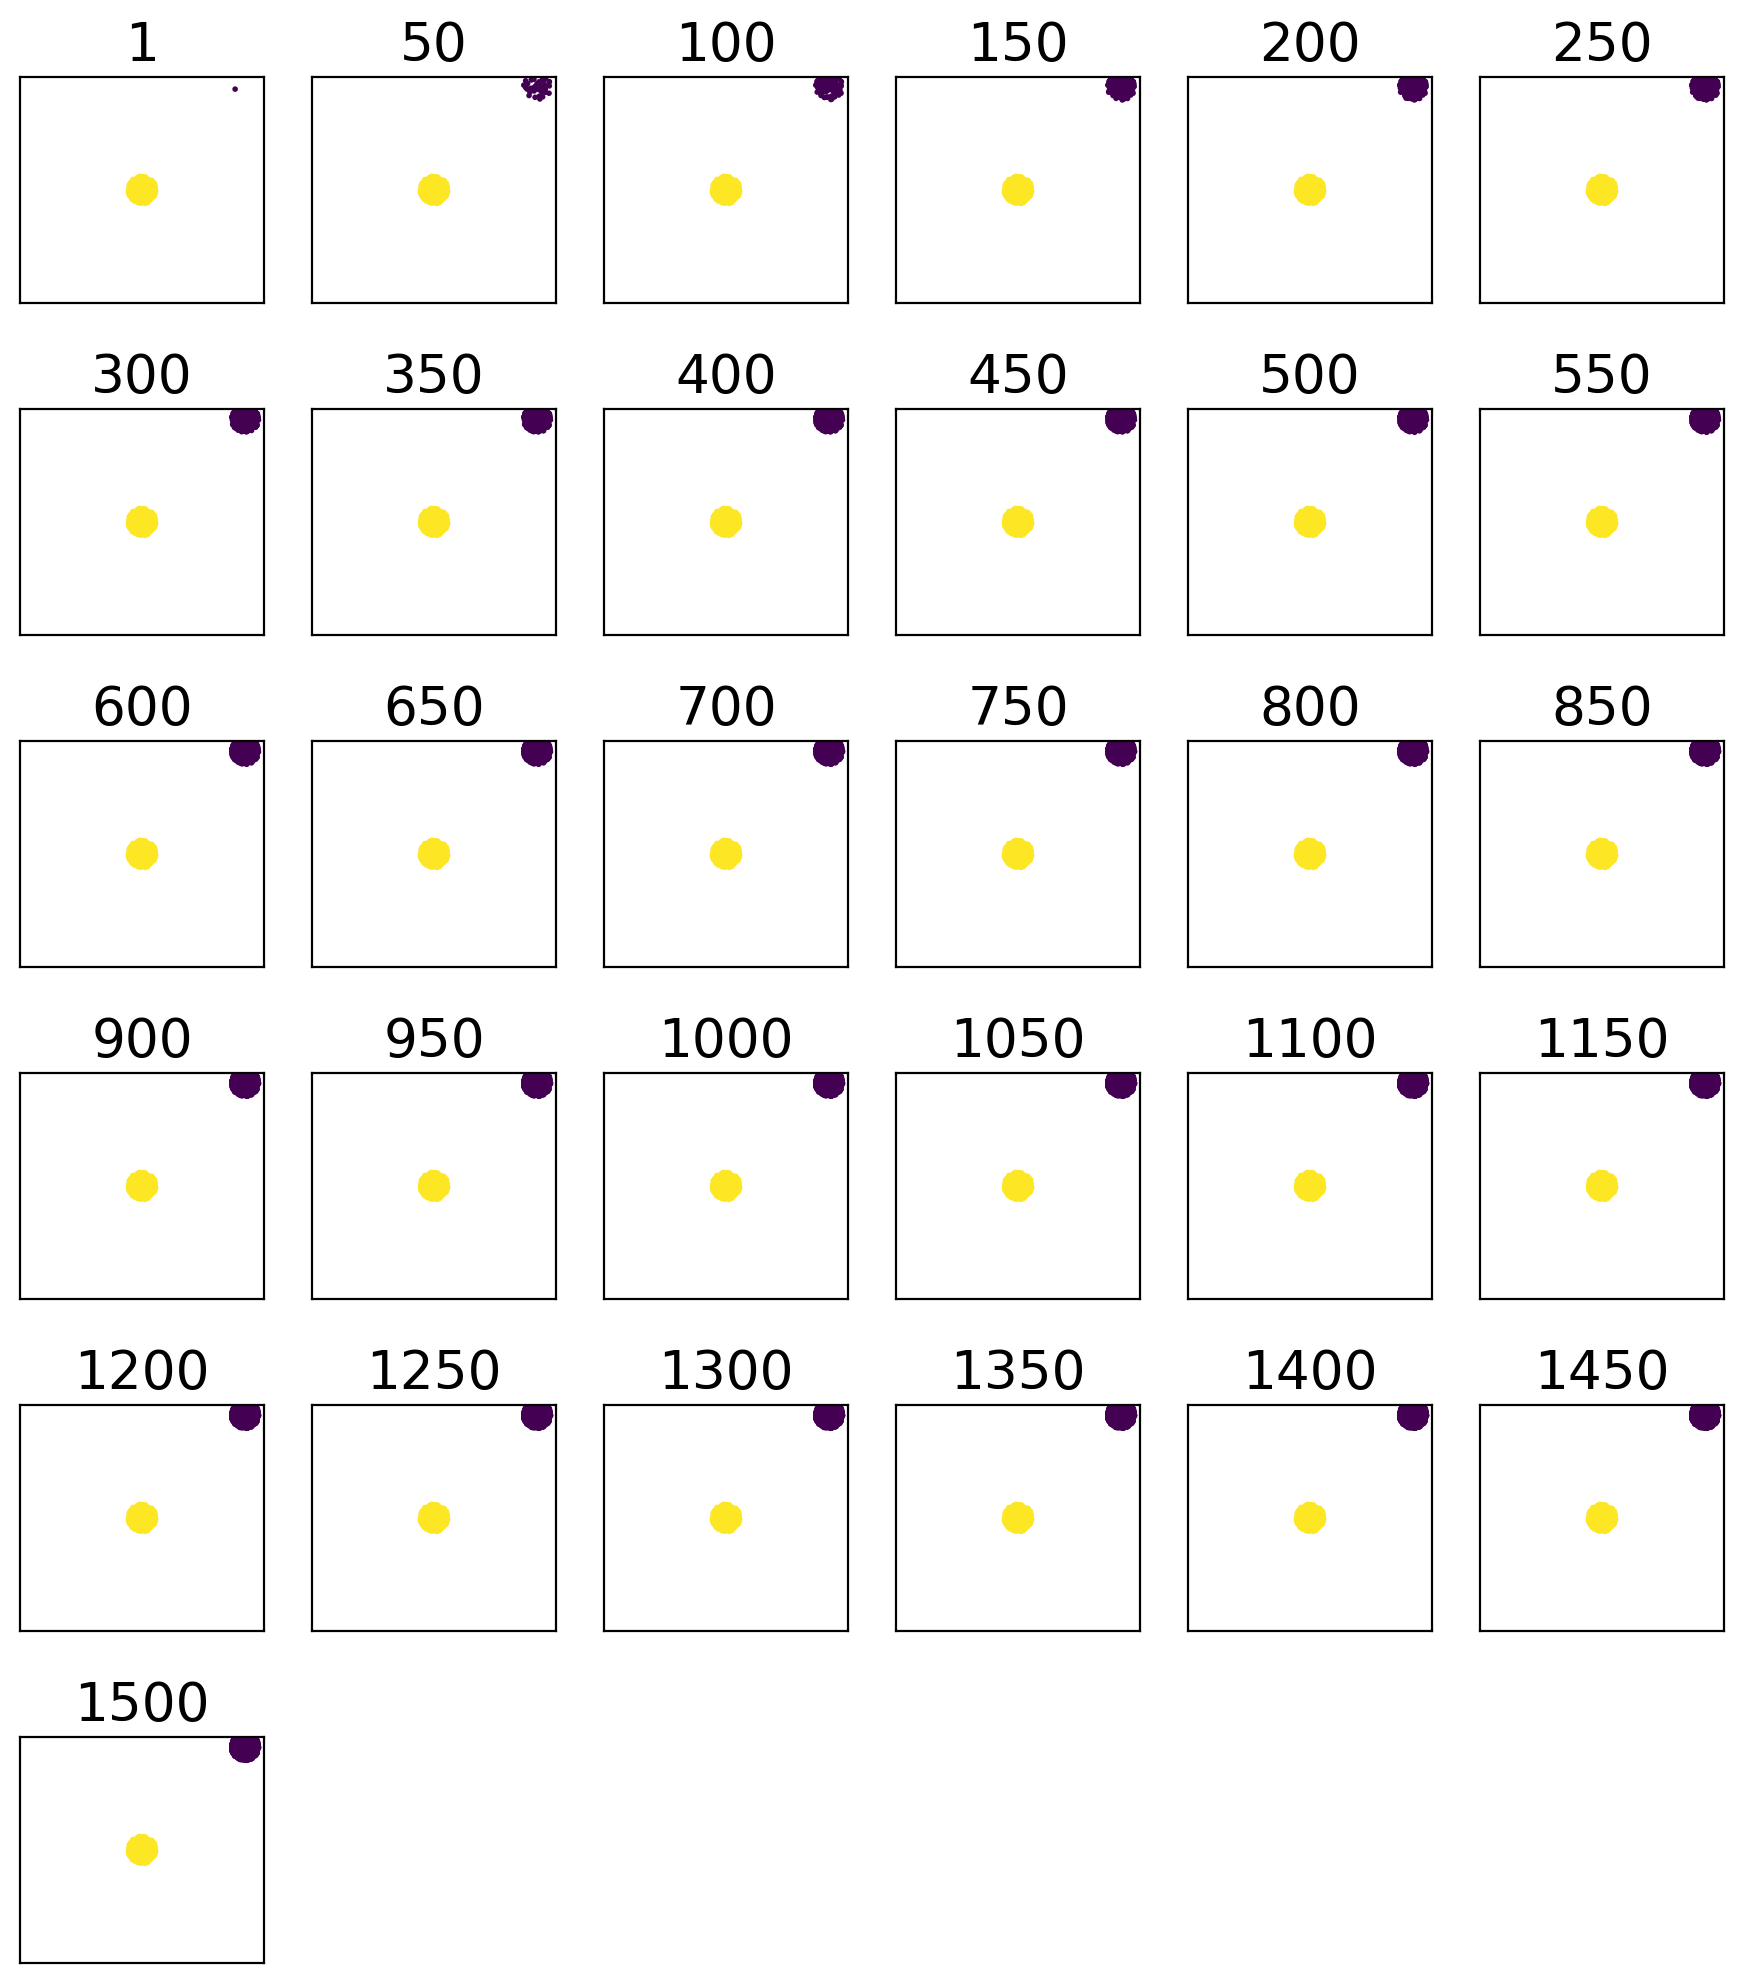

In [13]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets


fig = plot_datasets(blob_noise_grow_datasets, n_noises, figsize=1.5)

axes = fig.get_axes()
for ax in axes:
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.set_aspect("equal", adjustable="datalim")

plt.savefig("imgs/Noise_grow_data.png", bbox_inches="tight", pad_inches=0)

In [169]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.disco import disco_samples, p_noise, p_cluster, disco_score

metrics = {
    "DISCO": disco_score,
    "$\\rho_{cluster}$": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "$\\rho_{sparse}$": lambda X, l: np.mean(p_noise(X, l)[0]),
    "$\\rho_{far}$": lambda X, l: np.mean(p_noise(X, l)[1]),
}

n_noises_ratios = list(map(lambda x: round(x / 500 * 100, 1), n_noises))
eval_results = cache(
    "Noise_grow",
    calc_eval_measures_for_multiple_datasets,
    [blob_noise_grow_datasets, n_noises_ratios],
    {"metrics": metrics},
    recalc=False,
)

df = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[]) # "CH", "DC_DUNN", "DB", "DUNN", "CVDD"])

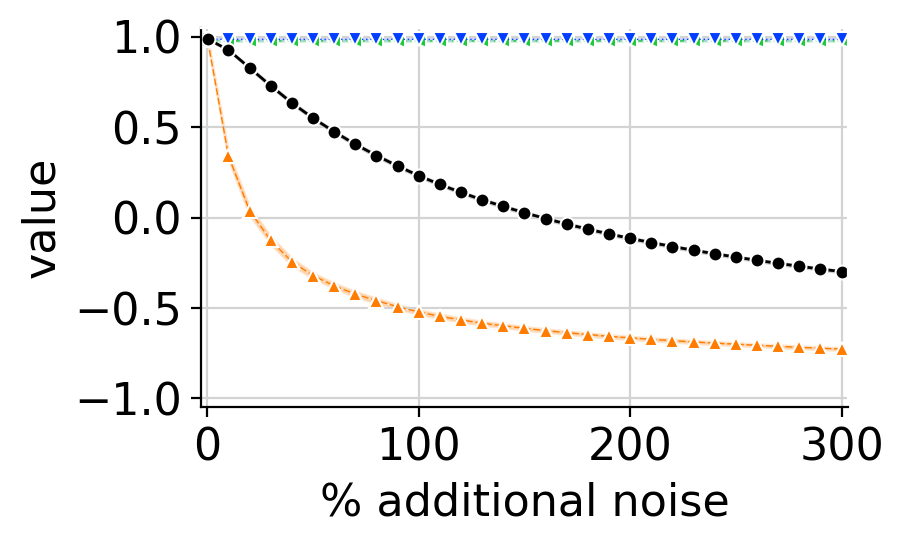

In [170]:
from src.utils.plots import plot_lineplot

eps = 3
x_range = n_noises_ratios[0] - eps, n_noises_ratios[-1] + eps

fig2 = plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    x_range=x_range,
    y_range=(-1.05, 1.05),
    order=list(metrics.keys()),
    figsize=(4.8, 3),
    highlight=1,
    ncol=1,
)
ax2 = fig2.gca()
# ax.set_xticks(range(0, 6, 3))
ax2.set_yticks(np.arange(-1, 1.04, 0.5))

leg = ax2.get_legend()
leg.set_loc("center left")
leg.set_bbox_to_anchor((1, 0.5))
leg.remove()
plt.savefig("imgs/Noise_grow.png", bbox_inches="tight", pad_inches=0)

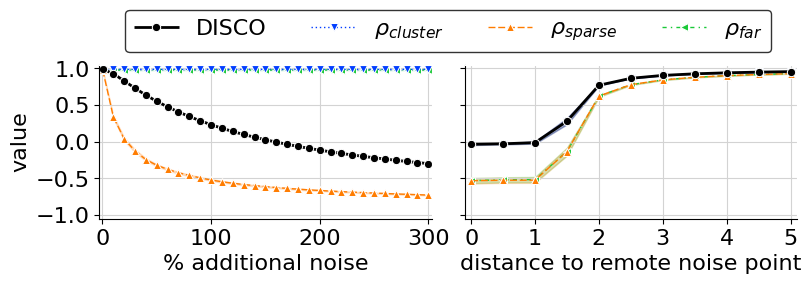

In [189]:
from src.utils.plots import plot_lineplot

fig, (ax2_, ax1_) = plt.subplots(1, 2, sharey=True, figsize=(9, 2))
plt.subplots_adjust(wspace=0.1)


eps = 0.2
x_range = dists[0] - eps, dists[-1] + eps
x_range = -0.1, 5.1

plot_lineplot(
    df2,
    "dataset",
    "value",
    "measure",
    x_label="distance to remote noise point",
    x_range=x_range,
    y_range=(-1.05, 1.05),
    order=list(metrics.keys()),
    figsize=(7, 3),
    highlight=1,
    ncol=1,
    fig=fig,
    ax=ax1_,
)
ax1_.set_xticks(range(0, 6, 1))
ax1_.set_yticks(np.arange(-1, 1.04, 0.5))

eps = 3
x_range = n_noises_ratios[0] - eps, n_noises_ratios[-1] + eps

plot_lineplot(
    df,
    "dataset",
    "value",
    "measure",
    x_label="% additional noise",
    x_range=x_range,
    y_range=(-1.05, 1.05),
    order=list(metrics.keys()),
    figsize=(7, 3),
    highlight=1,
    ncol=4,
    fig=fig,
    ax=ax2_,
)
# ax.set_xticks(range(0, 6, 3))
ax2_.set_yticks(np.arange(-1, 1.04, 0.5))

# leg = fig.gca().get_legend()
# leg.set_loc("center left")
# leg.set_bbox_to_anchor((1, 0.5))

leg = fig.gca().get_legend()
leg.set_loc("lower center")
leg.set_bbox_to_anchor((-0.05, 1.01))

ax2_.get_legend().remove()

plt.savefig("imgs/Noise_both.png", bbox_inches="tight", pad_inches=0.1)
plt.show()

In [12]:
import numpy as np
from functools import reduce

X = np.array(
    reduce(lambda points, elem: points + [[points[-1][0] + elem, 0]], range(1, 101), [[0, 0]])
)
line_noise = [[(X, np.array([0] * (len(X) - i) + [-1] * i)) for seed in [0]] for i in range(0,102)]
line_nr = range(102)

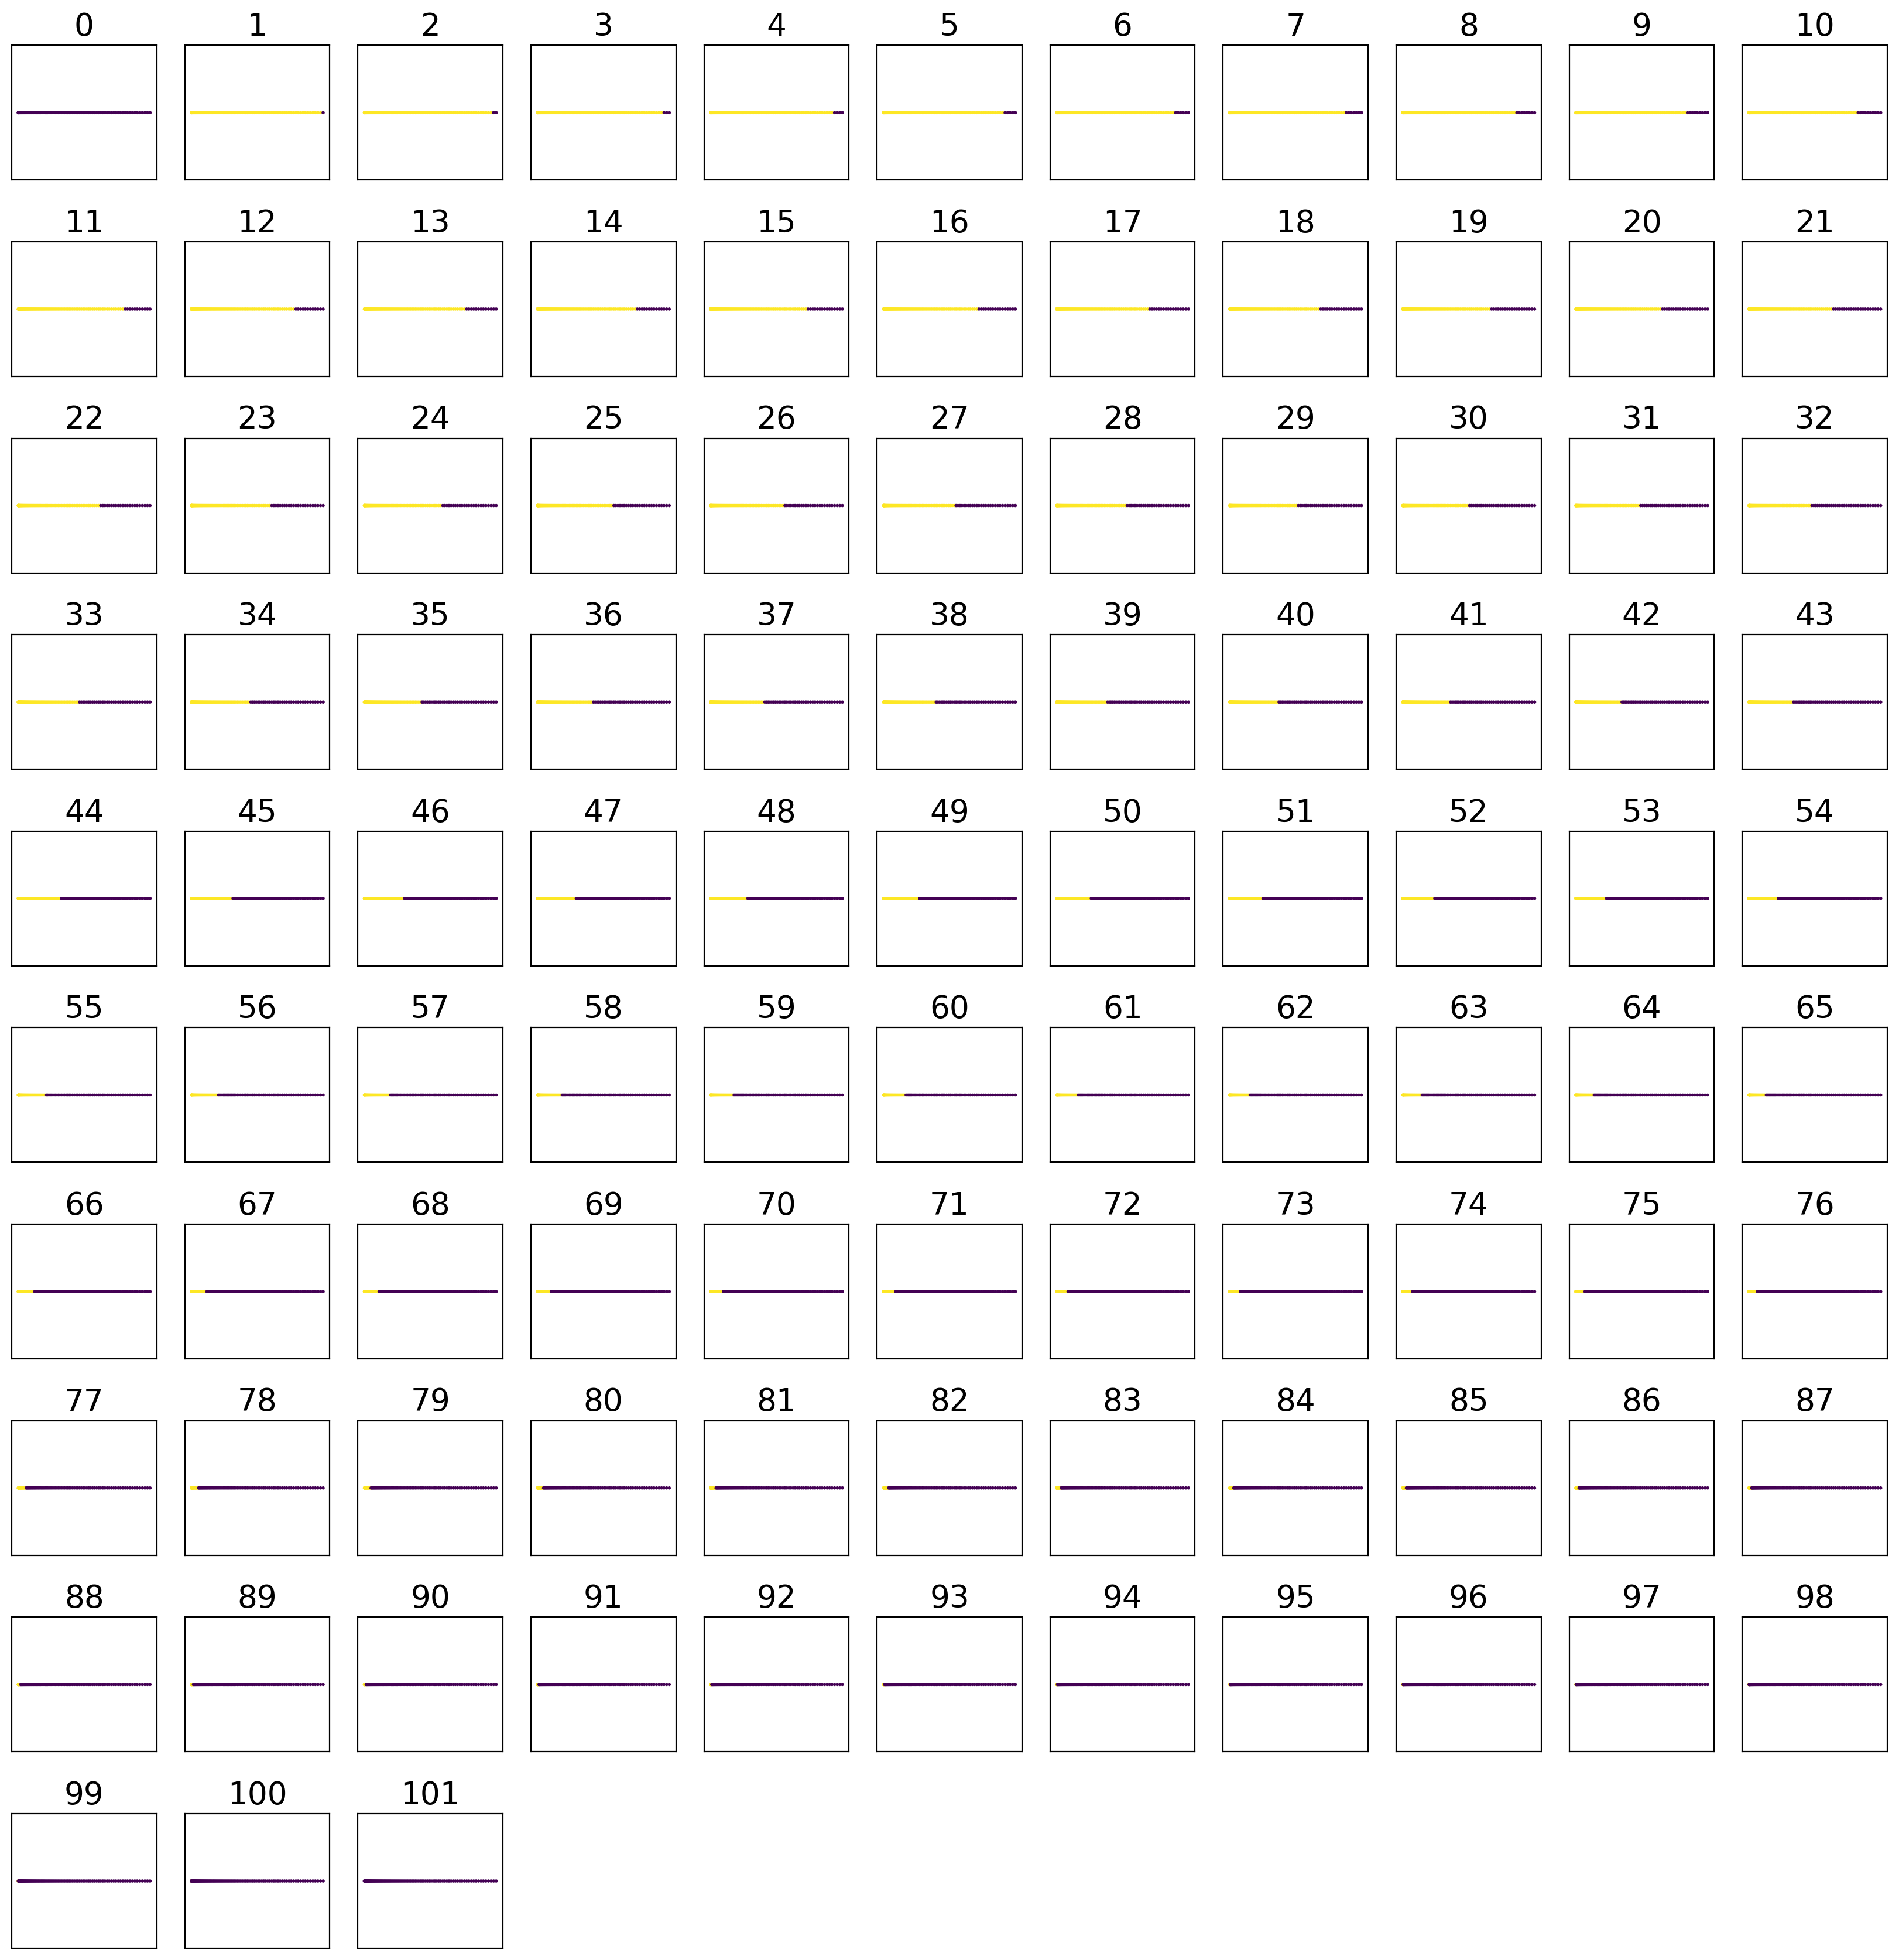

In [13]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(line_noise, line_nr, figsize=1.5)
plt.savefig("imgs/Noise_line_data.png")

In [14]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.DISCO.disco import disco_samples, only_noise_samples, only_disco_samples, disco_score


metrics = {
    "DISCO": disco_score,
    "non_noise": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "core_prop": lambda X, l: np.mean(only_noise_samples(X, l)[0]),
    "dc_prop": lambda X, l: np.mean(only_noise_samples(X, l)[1]),
    "noise_eval": lambda X, l: np.mean(np.minimum(*only_noise_samples(X, l))),
}

eval_results = cache(
    "Noise_line",
    calc_eval_measures_for_multiple_datasets,
    [line_noise, line_nr],
    {"metrics": metrics},
    recalc=True,
)

df = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[]) # "CH", "DC_DUNN", "DB", "DUNN", "CVDD"])

/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/e

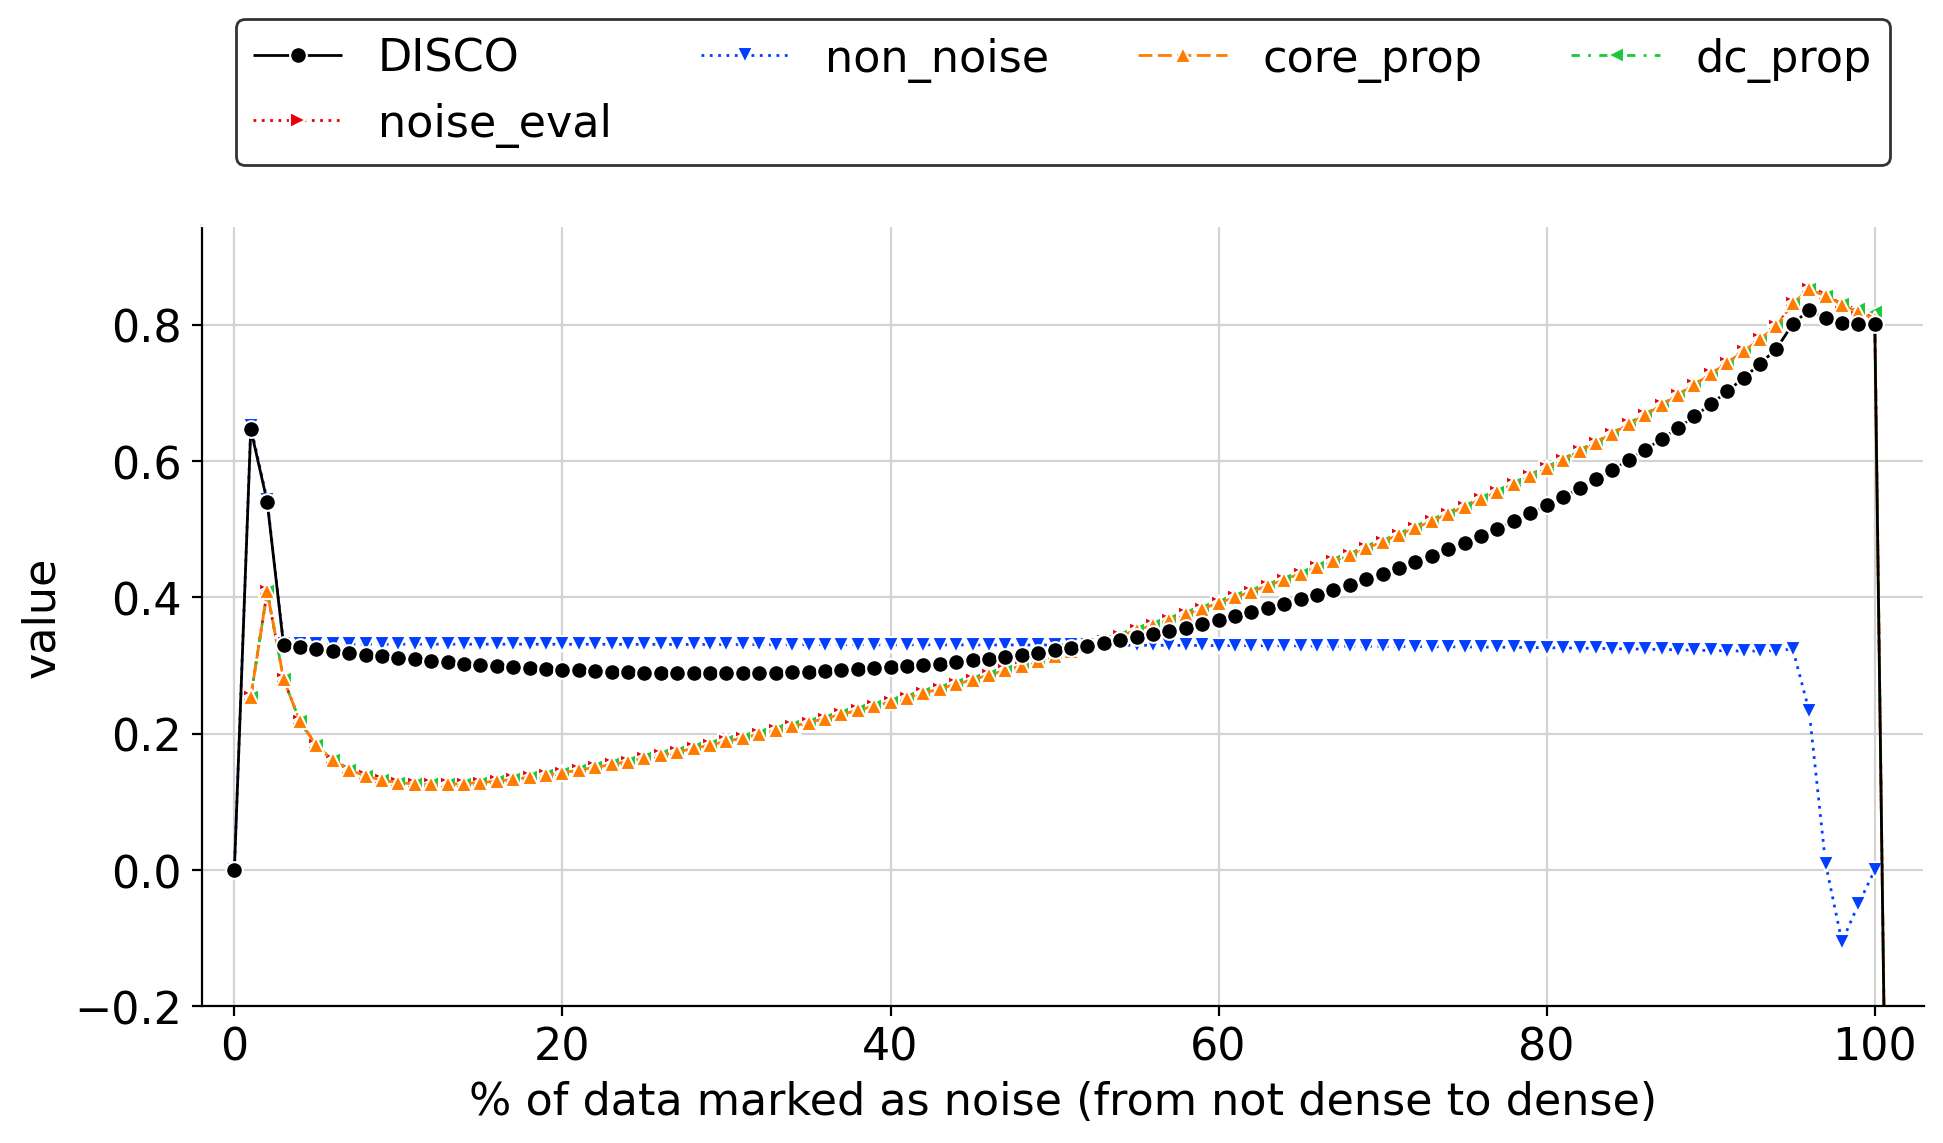

In [15]:
from src.utils.plots import plot_lineplot

eps = 2
x_range = line_nr[0] - eps, line_nr[-1] + eps

plot_lineplot(
    df,
    x_axis="dataset",
    y_axis="value",
    grouping="measure",
    x_label="% of data marked as noise (from not dense to dense)",
    x_range=x_range,
    y_range=(-0.2, None),
    order=list(metrics.keys()),
    highlight_size=1,
)
plt.savefig("imgs/Noise_line.png")

In [16]:
import numpy as np
from functools import reduce

X = np.array(
    reduce(lambda points, elem: points + [[points[-1][0] + elem, 0]], range(1, 101), [[0, 0]])
)
line_noise = [[(X, np.array([-1] * (len(X) - i) + [0] * i)) for seed in [0]] for i in range(0,102)]
line_nr = range(102)

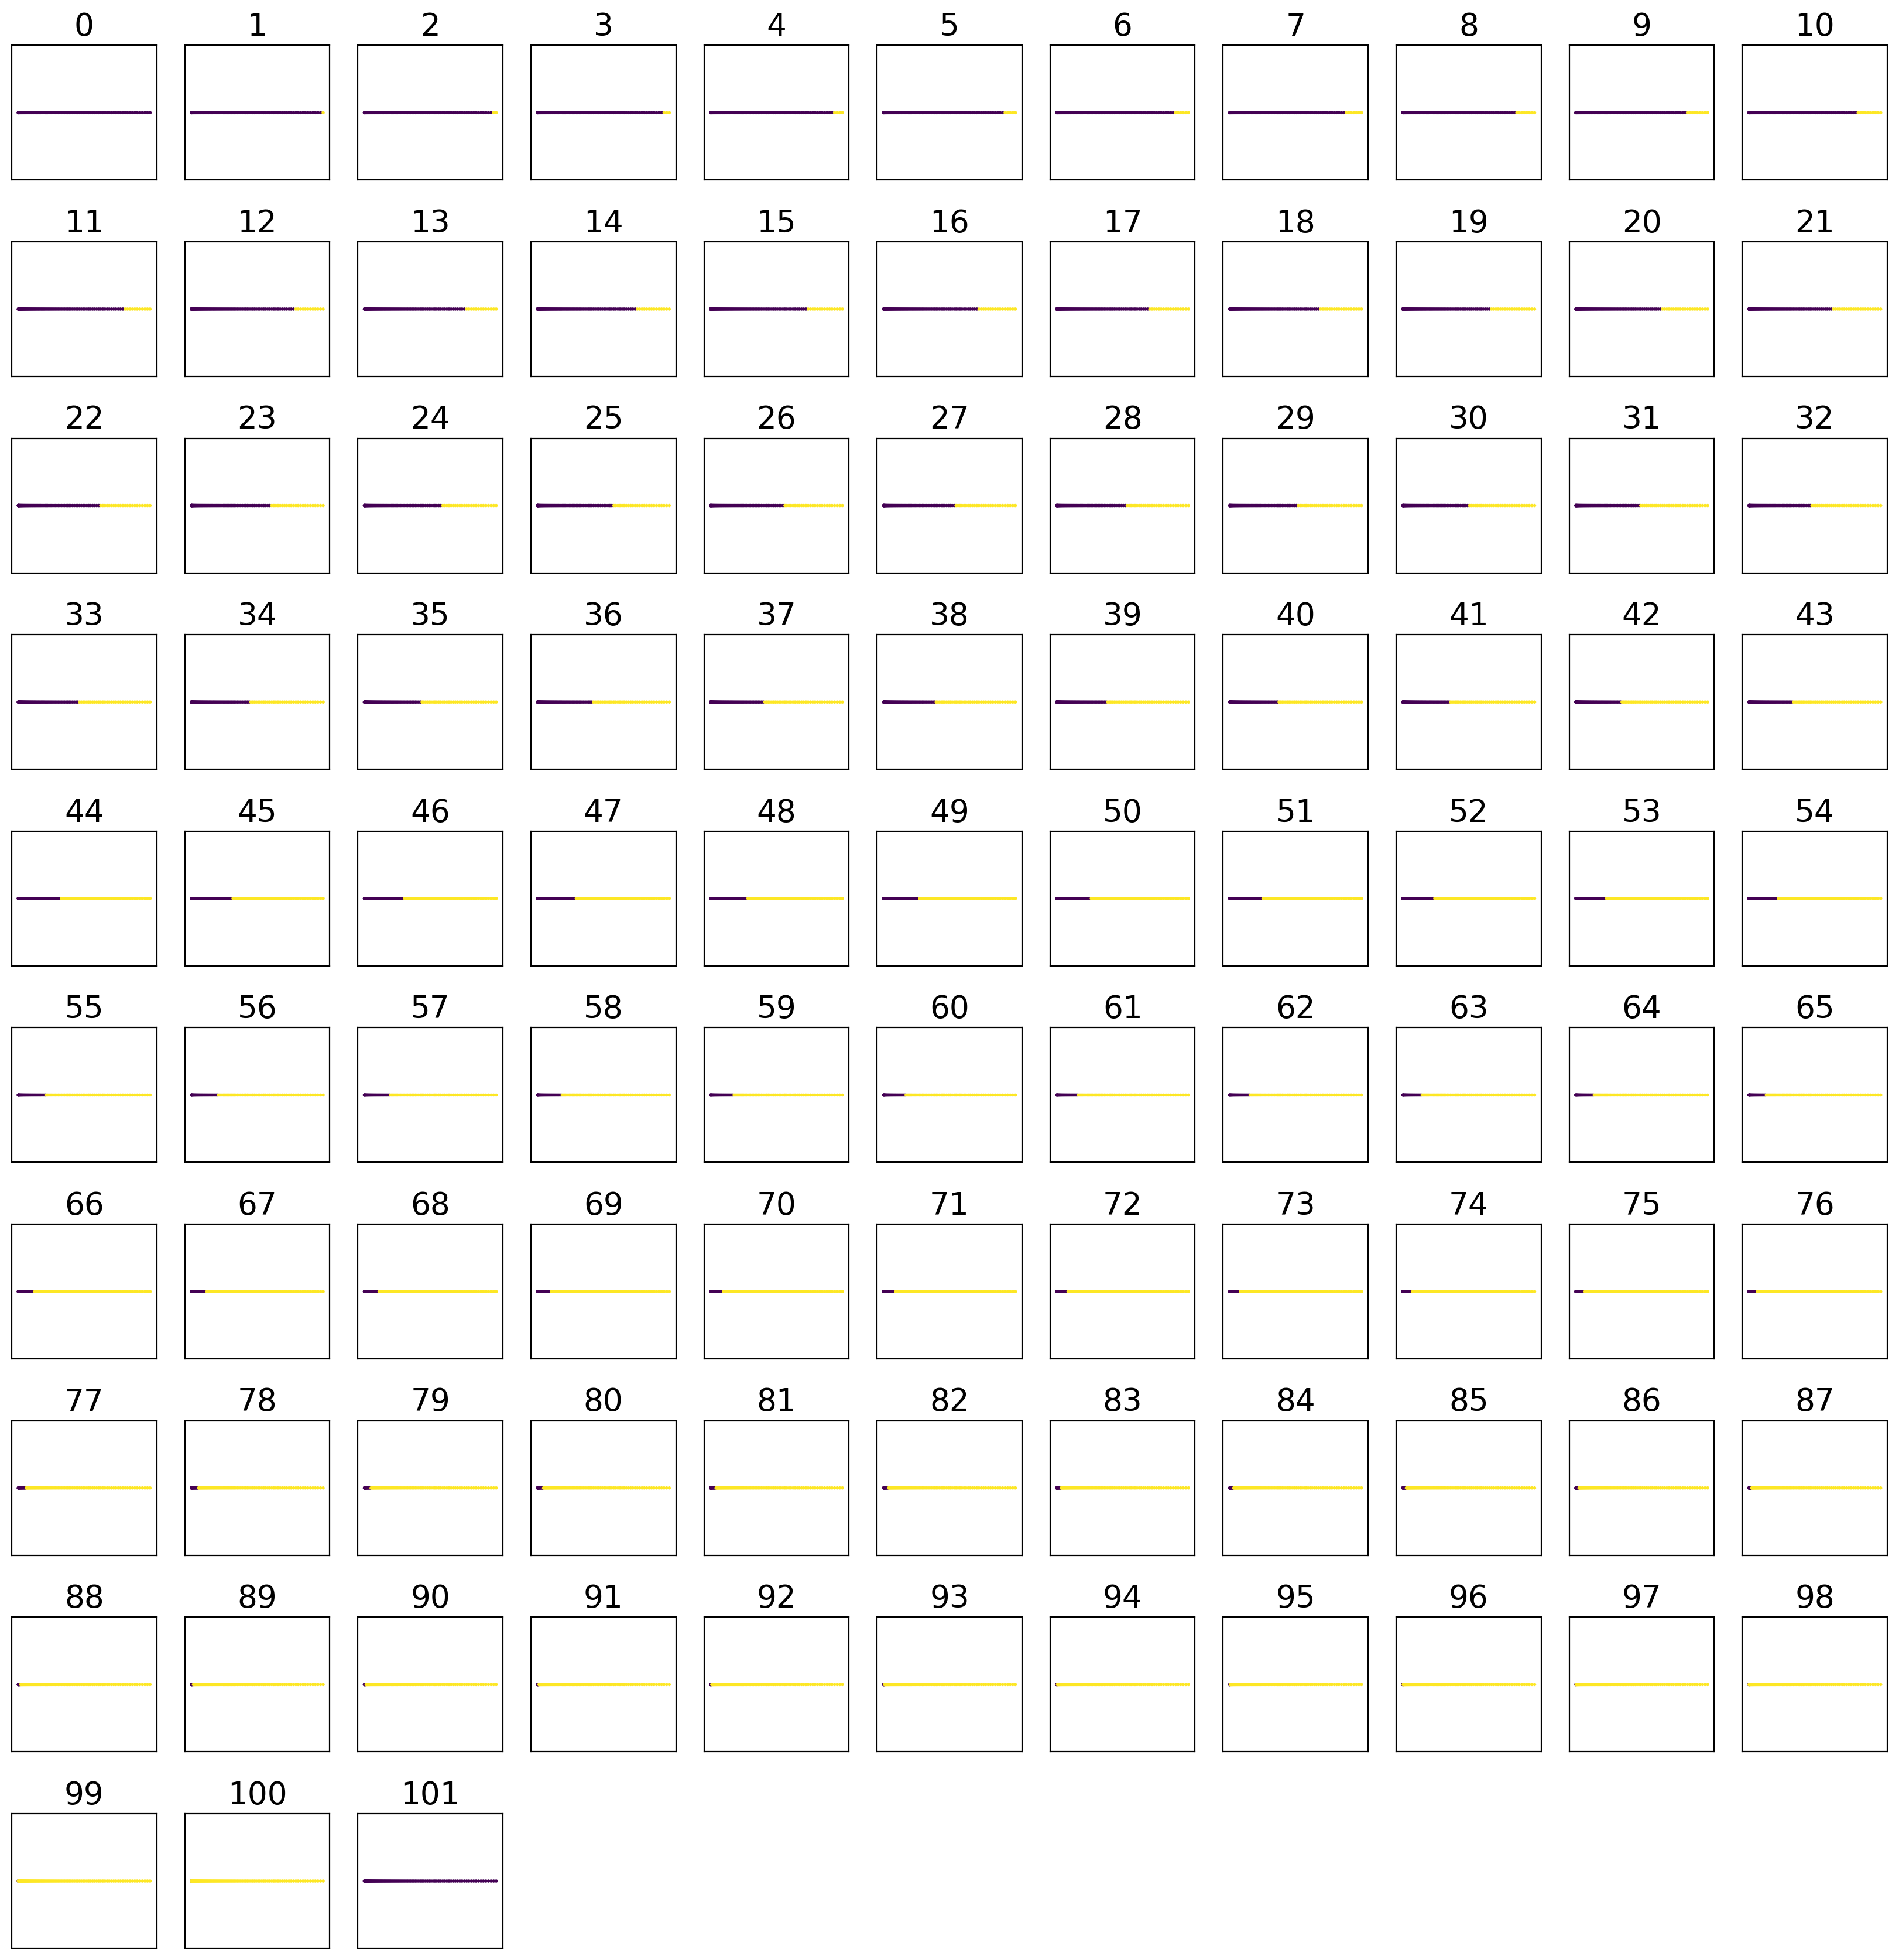

In [17]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(line_noise, line_nr, figsize=1.5)
plt.savefig("imgs/Noise_line_data_reverse.png")

In [18]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.DISCO.disco import disco_samples, only_noise_samples, only_disco_samples, disco_score


metrics = {
    "DISCO": disco_score,
    "non_noise": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "core_prop": lambda X, l: np.mean(only_noise_samples(X, l)[0]),
    "dc_prop": lambda X, l: np.mean(only_noise_samples(X, l)[1]),
    "noise_eval": lambda X, l: np.mean(np.minimum(*only_noise_samples(X, l))),
}

eval_results = cache(
    "Noise_line",
    calc_eval_measures_for_multiple_datasets,
    [line_noise, line_nr],
    {"metrics": metrics},
    recalc=True,
)

df = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[]) # "CH", "DC_DUNN", "DB", "DUNN", "CVDD"])

/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/e

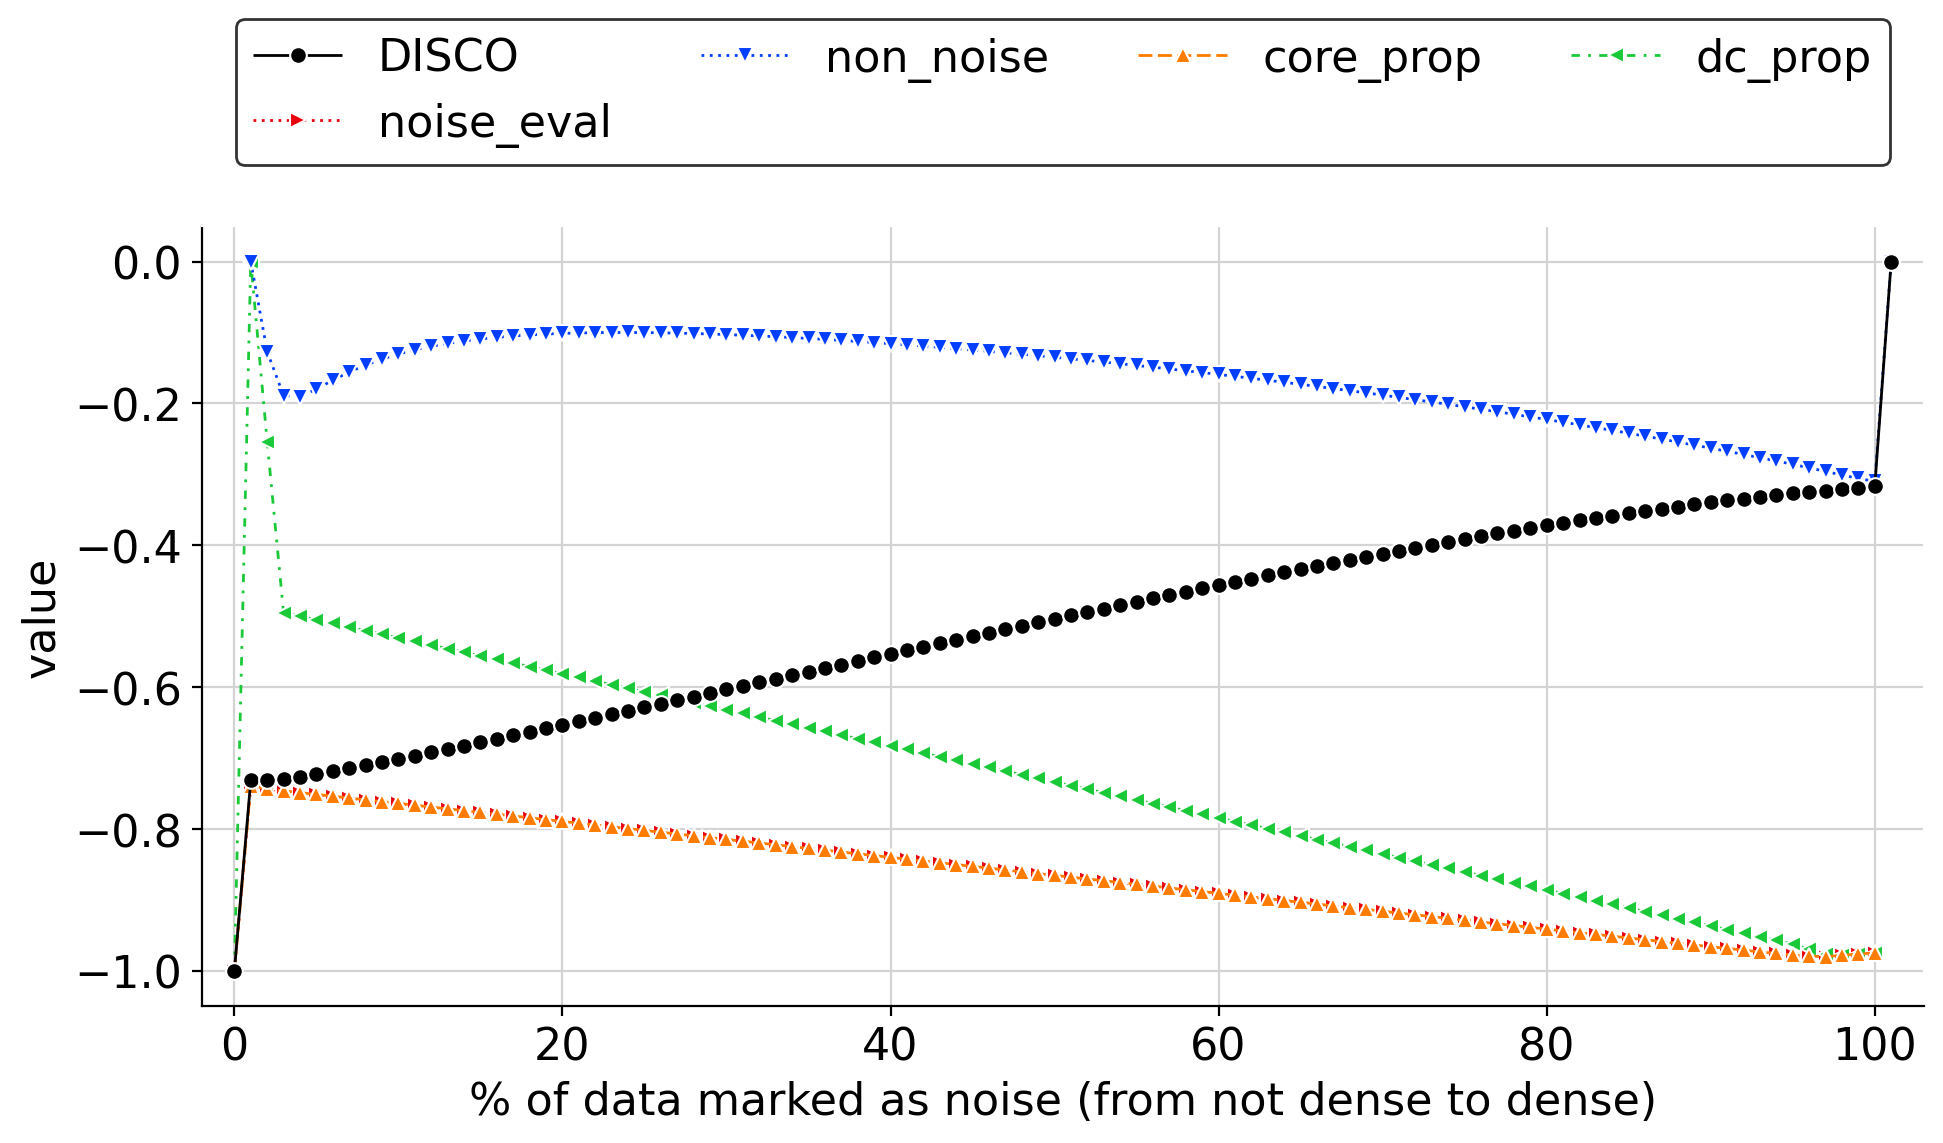

In [21]:
from src.utils.plots import plot_lineplot

eps = 2
x_range = line_nr[0] - eps, line_nr[-1] + eps

plot_lineplot(
    df,
    x_axis="dataset",
    y_axis="value",
    grouping="measure",
    x_label="% of data marked as noise (from not dense to dense)",
    x_range=x_range,
    y_range=(None, None),
    order=list(metrics.keys()),
    highlight_size=1,
)
plt.savefig("imgs/Noise_line_reverse.png")

In [26]:
import numpy as np
from functools import reduce

X = np.array(
    reduce(lambda points, elem: points + [[points[-1][0] * 2, 0]], range(1, 101), [[1, 0]])
)
line_noise = [[(X, np.array([0] * (len(X) - i) + [-1] * i)) for seed in [0]] for i in range(0,102)]
line_nr = range(102)

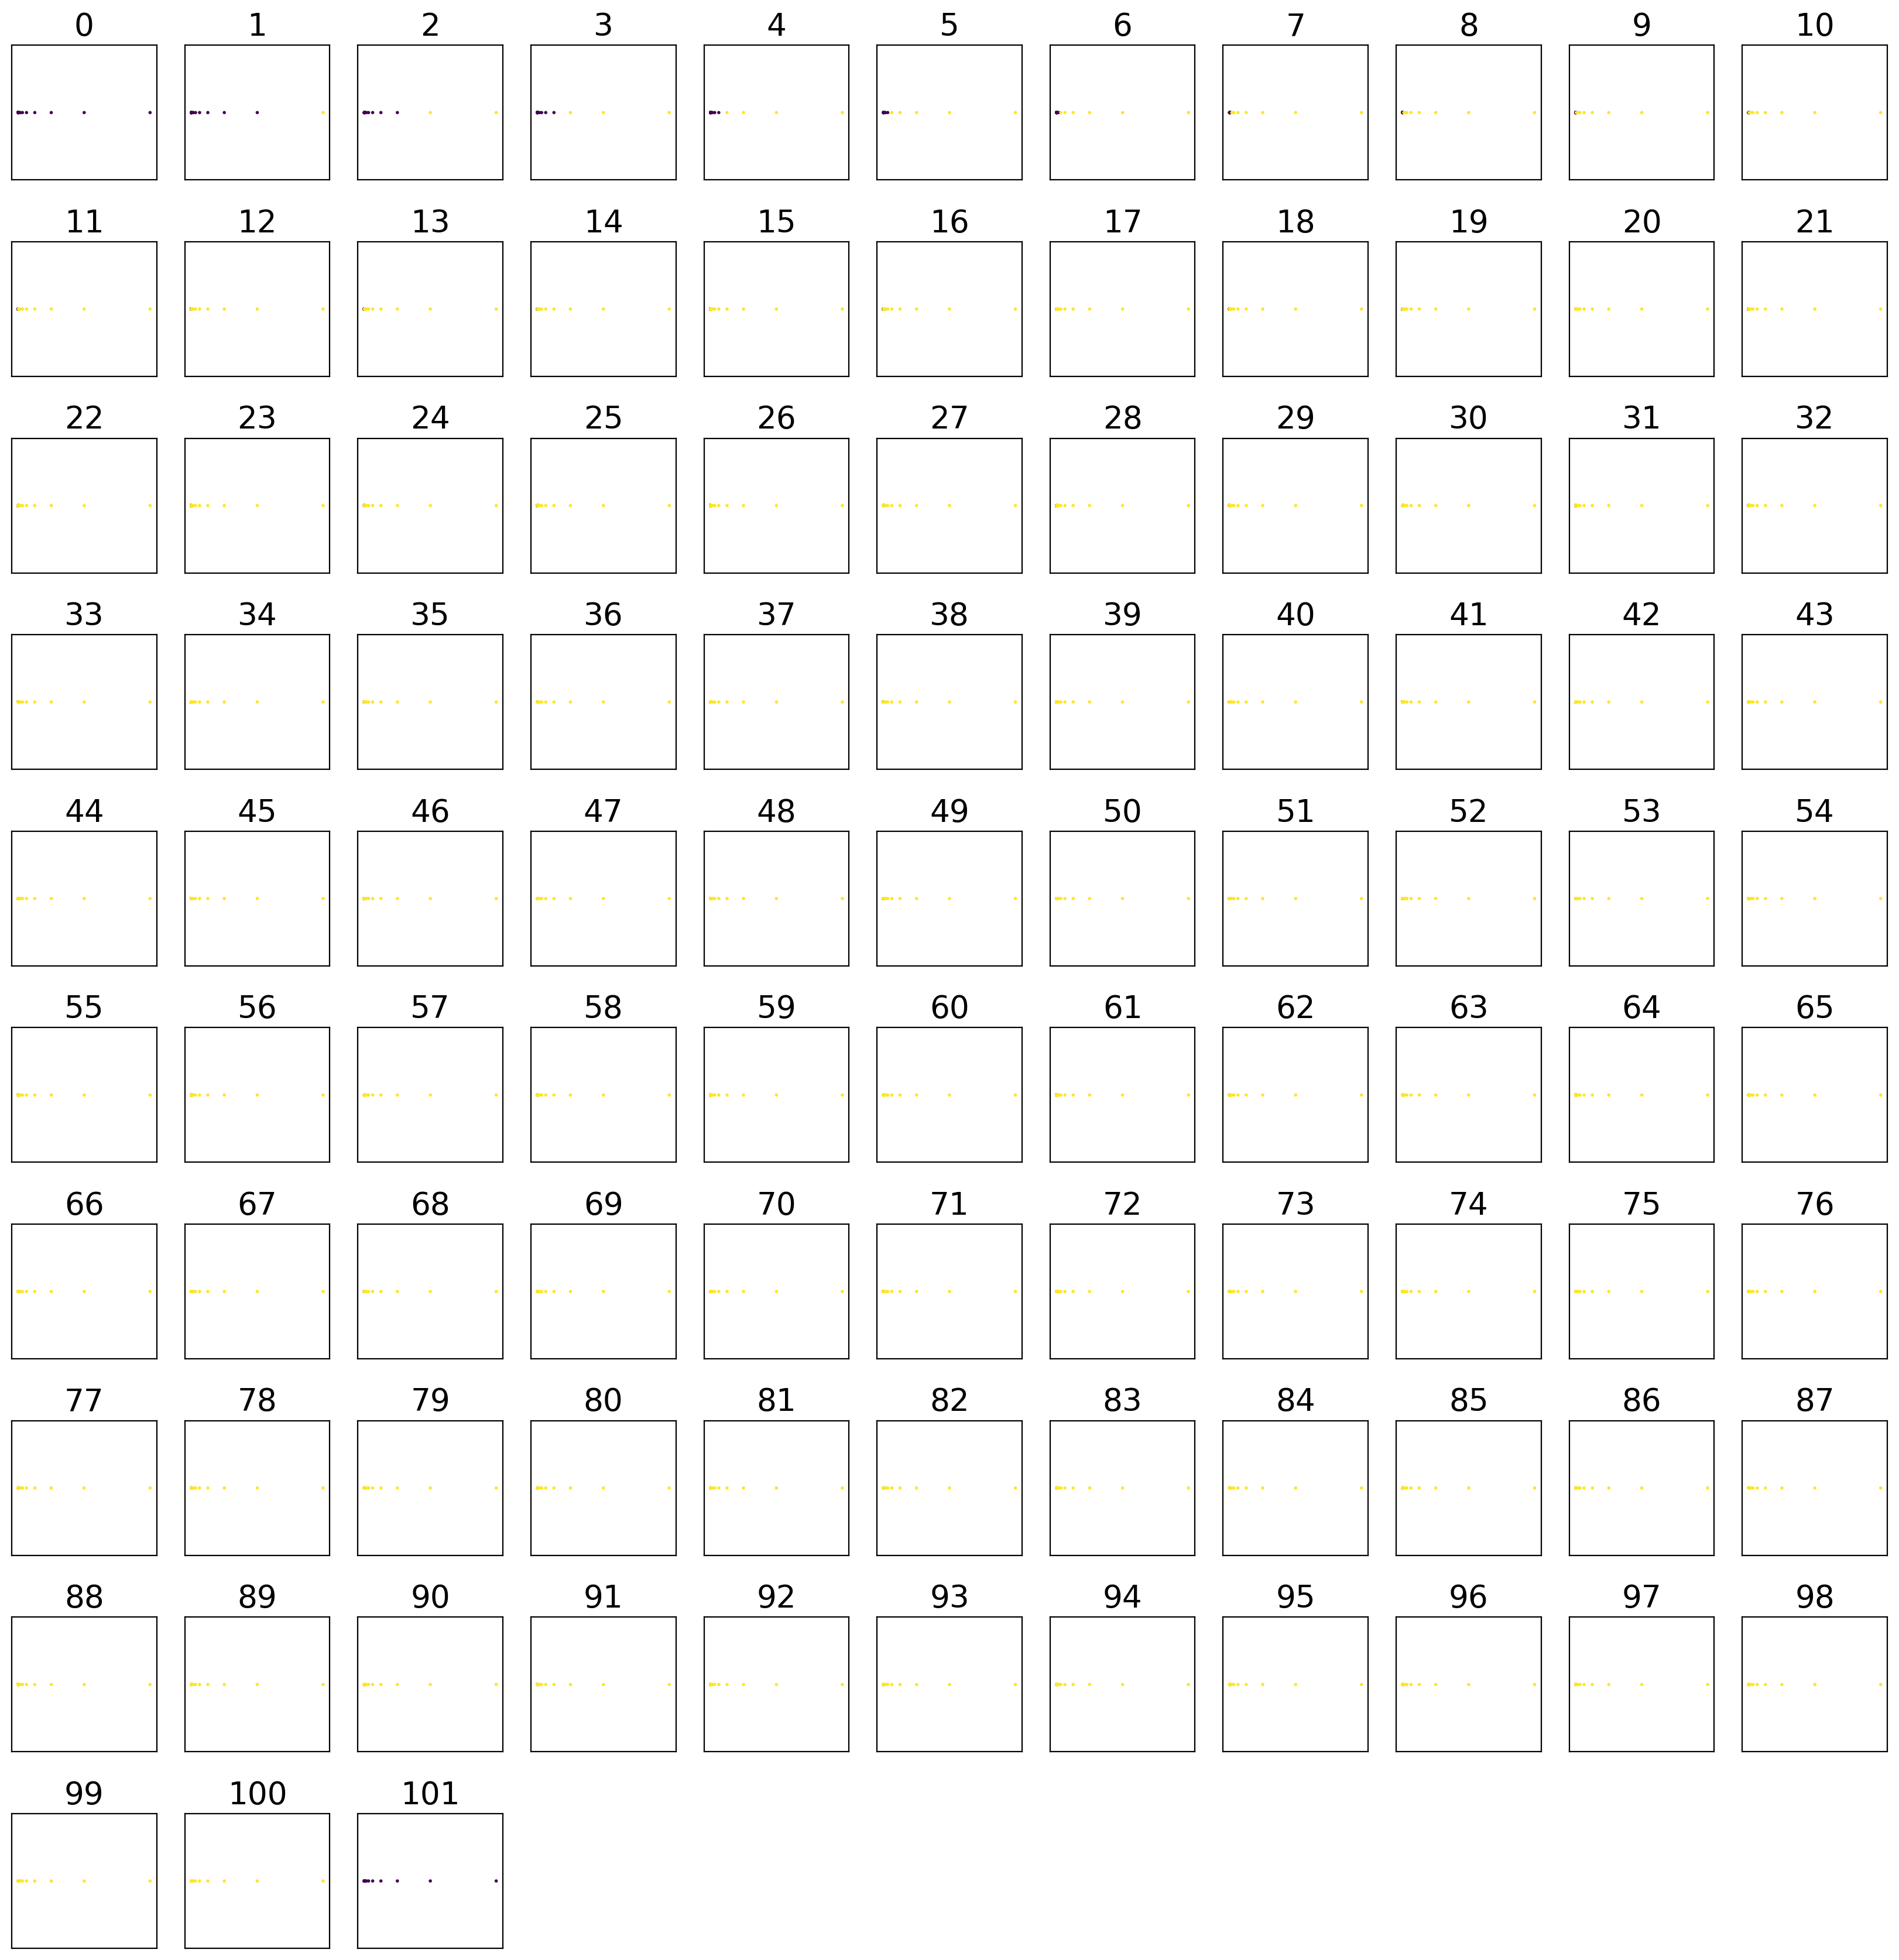

In [35]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(line_noise, line_nr, figsize=1.5)
plt.savefig("imgs/Noise_line_data2.png")

In [28]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.DISCO.disco import disco_samples, only_noise_samples, only_disco_samples, disco_score


metrics = {
    "DISCO": disco_score,
    "non_noise": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "core_prop": lambda X, l: np.mean(only_noise_samples(X, l)[0]),
    "dc_prop": lambda X, l: np.mean(only_noise_samples(X, l)[1]),
    "noise_eval": lambda X, l: np.mean(np.minimum(*only_noise_samples(X, l))),
}

eval_results = cache(
    "Noise_line",
    calc_eval_measures_for_multiple_datasets,
    [line_noise, line_nr],
    {"metrics": metrics},
    recalc=True,
)

df = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[]) # "CH", "DC_DUNN", "DB", "DUNN", "CVDD"])

/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/e

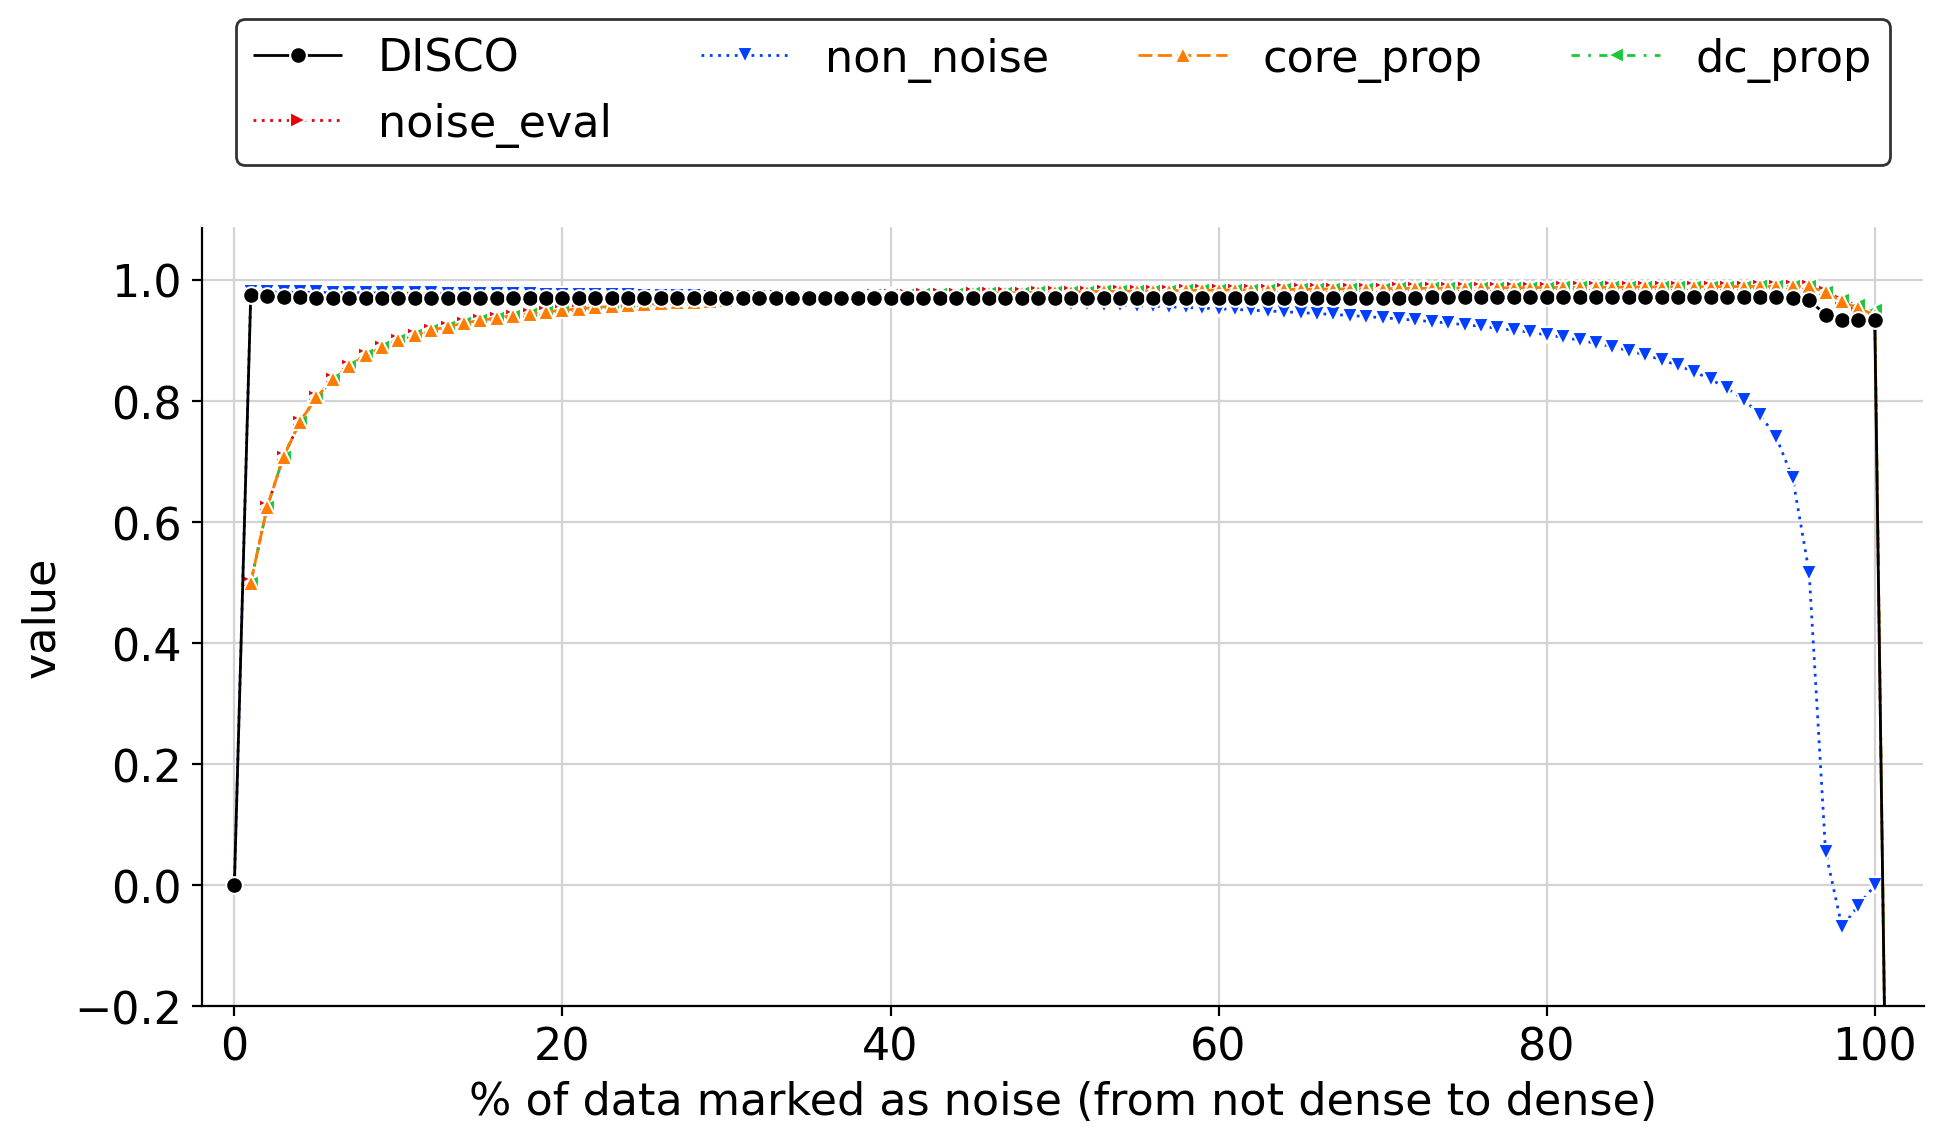

In [29]:
from src.utils.plots import plot_lineplot

eps = 2
x_range = line_nr[0] - eps, line_nr[-1] + eps

plot_lineplot(
    df,
    x_axis="dataset",
    y_axis="value",
    grouping="measure",
    x_label="% of data marked as noise (from not dense to dense)",
    x_range=x_range,
    y_range=(-0.2, None),
    order=list(metrics.keys()),
    highlight_size=1,
)
plt.savefig("imgs/Noise_line2.png")

In [30]:
import numpy as np
from functools import reduce

X = np.array(
    reduce(lambda points, elem: points + [[points[-1][0] * 2, 0]], range(1, 101), [[1, 0]])
)
line_noise = [[(X, np.array([-1] * (len(X) - i) + [0] * i)) for seed in [0]] for i in range(0,102)]
line_nr = range(102)

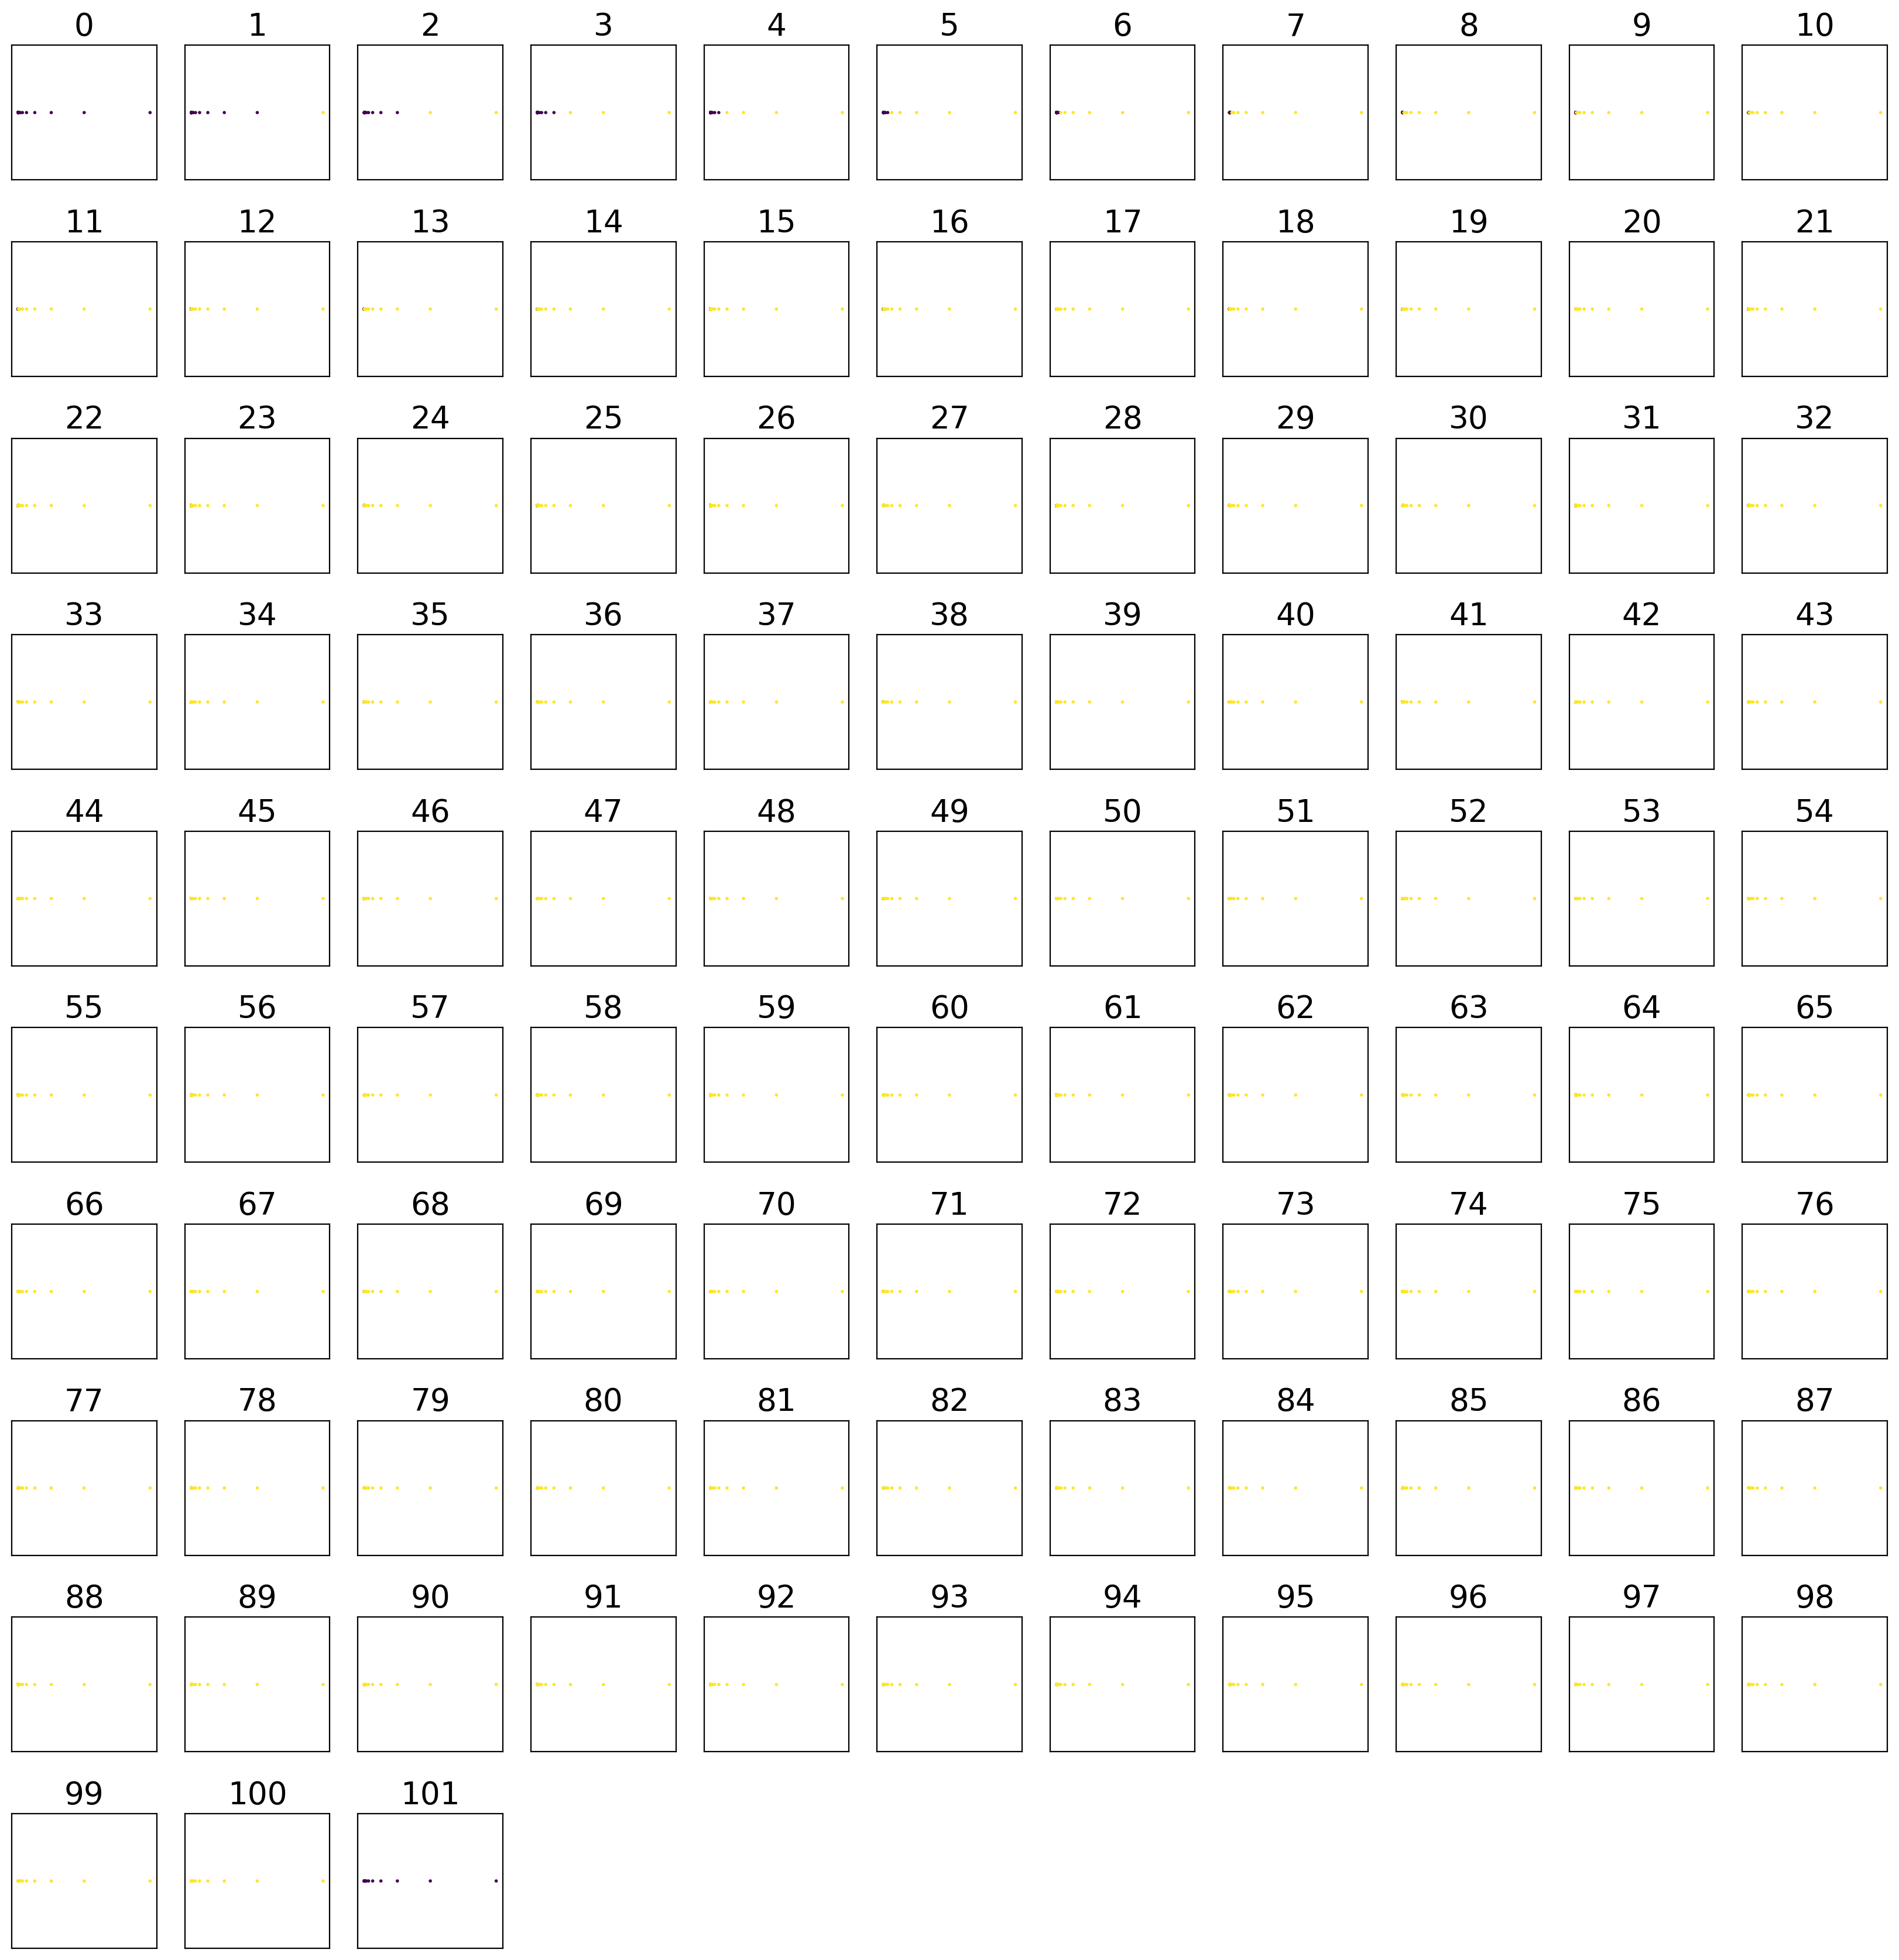

In [34]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_datasets

fig = plot_datasets(line_noise, line_nr, figsize=1.5)
plt.savefig("imgs/Noise_line_data2_reverse.png")

In [32]:
from src.utils.experiments import cache, calc_eval_measures_for_multiple_datasets
from src.utils.metrics import create_and_rescale_df, METRICS, SELECTED_METRICS
from src.Evaluation.DISCO.disco import disco_samples, only_noise_samples, only_disco_samples, disco_score


metrics = {
    "DISCO": disco_score,
    "non_noise": lambda X, l: np.mean(disco_samples(X, l)[l != -1]),
    "core_prop": lambda X, l: np.mean(only_noise_samples(X, l)[0]),
    "dc_prop": lambda X, l: np.mean(only_noise_samples(X, l)[1]),
    "noise_eval": lambda X, l: np.mean(np.minimum(*only_noise_samples(X, l))),
}

eval_results = cache(
    "Noise_line",
    calc_eval_measures_for_multiple_datasets,
    [line_noise, line_nr],
    {"metrics": metrics},
    recalc=True,
)

df = create_and_rescale_df(eval_results, selected_metrics=metrics, excluded_metrics=[]) # "CH", "DC_DUNN", "DB", "DUNN", "CVDD"])

/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/export/share/pascalw777dm/miniconda3/envs/stuff/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/e

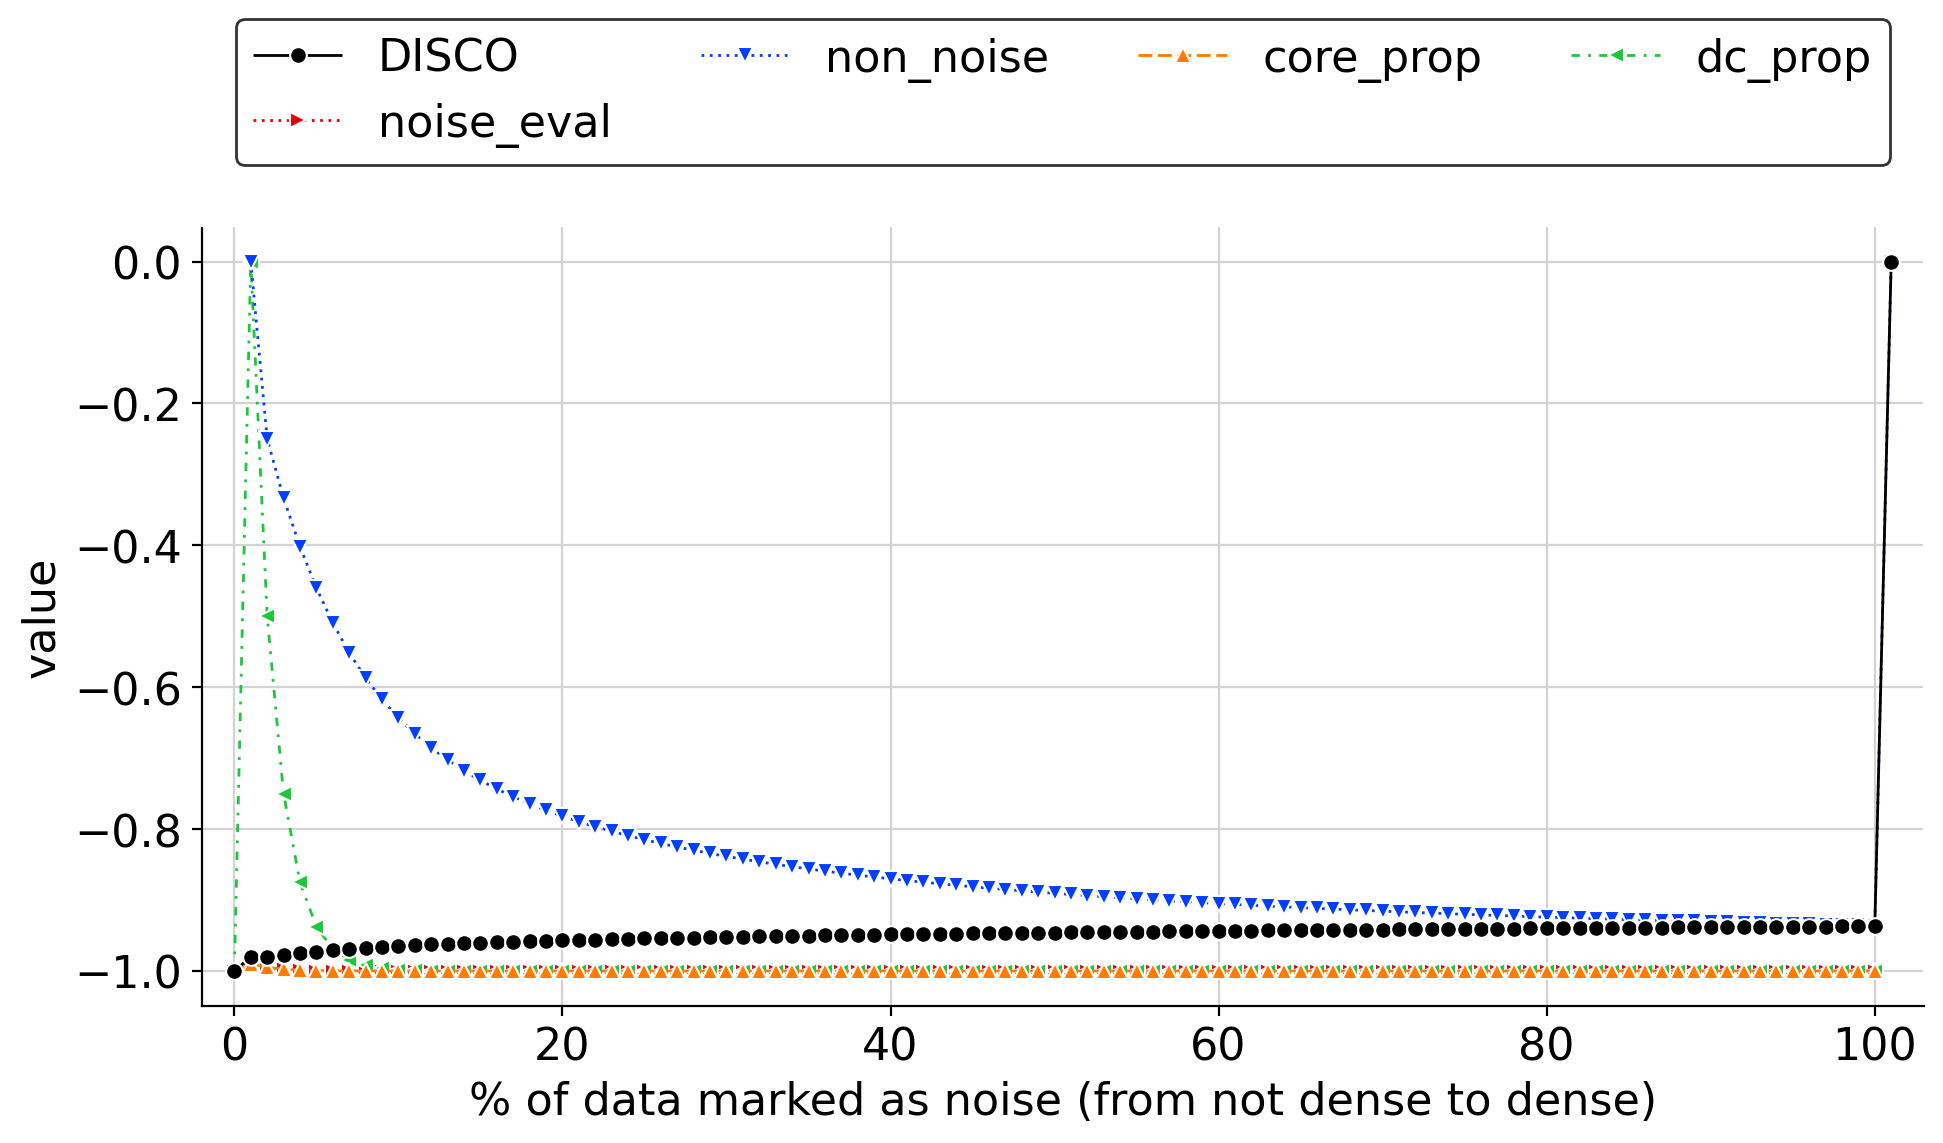

In [36]:
from src.utils.plots import plot_lineplot

eps = 2
x_range = line_nr[0] - eps, line_nr[-1] + eps

plot_lineplot(
    df,
    x_axis="dataset",
    y_axis="value",
    grouping="measure",
    x_label="% of data marked as noise (from not dense to dense)",
    x_range=x_range,
    y_range=(None, None),
    order=list(metrics.keys()),
    highlight_size=1,
)
plt.savefig("imgs/Noise_line2_reverse.png")